# Setup

Setup and Library Imports

In [1]:
# Install required packages
!pip install gensim
!pip install numpy==1.25.0
!pip install bertopic
!pip install scikit-learn umap-learn hdbscan sentence-transformers
!pip install bokeh plotly.express
!pip install python-louvain

In [2]:
# Import required libraries
import requests
import time
import random
from datetime import datetime
import networkx as nx
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from sentence_transformers import SentenceTransformer
import random
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import torch
import ast
import unicodedata
from scipy.cluster.hierarchy import linkage, leaves_list

In [3]:
# NLTK data download
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Data Acquisition (API Access)

In [4]:
# Collect video metadata
api_url = "https://www.osti.gov/sciencecinema/api/v1/records"
response = requests.get(api_url)

print(response.status_code)

if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print(f"Error: Received status code {response.status_code}")
    print(response.text)

if response.status_code == 200 and isinstance(data, list) and len(data) > 0:
    first_record = data[0]
    print(first_record.keys())

if response.status_code == 200 and isinstance(data, list):
    for record in data:
        video_id = record.get('osti_id')
        links = record.get('links')
        print(f"Links for video ID: {video_id}")
        if links:
            for link in links:
                print(f"  Rel: {link.get('rel')}, Href: {link.get('href')}")
        else:
            print("  No links found for this video.")
        print("-" * 20)
else:
    print("Could not retrieve video record list.")

200
[{'osti_id': '2320255', 'title': 'Materials for the Photoluminescence-Based Detection of Economically Critical Metals', 'product_type': 'Multimedia', 'language': 'English', 'country_publication': 'United States', 'description': 'Critical metals, such as rare earth elements (REEs), cobalt, lithium, aluminum, nickel, and others, are essential to advanced technologies and renewable energy in particular. Widespread global adoption of renewable energy technologies has spurred dramatic demand increases for these metals; however, the global supply of these metals is highly monopolistic and conventional mining poses economic and environmental challenges. As a result, there is increasing interest in domestic production from alternative resources such as coal and its utilization byproducts. Slow and expensive characterization costs remain a significant barrier for domestic production. Here, luminescent sensing materials and platforms are presented that provide an alternative to the current s

Collect Video Metadata

In [5]:
# Introducing rate limit handling
video_data = []
base_url = "https://www.osti.gov/sciencecinema/api/v1/records"
rows_per_page = 20
total_count = None
page = 1
max_retries = 5
initial_delay = 1

In [6]:
# Rate limit handling
while total_count is None or len(video_data) < total_count:
    params = {'format': 'json', 'page': page, 'rows': rows_per_page}
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()

            if response.status_code == 200 and isinstance(response.json(), list):
                current_page_data = response.json()
                video_data.extend(current_page_data)
                if total_count is None:
                    total_count = int(response.headers.get('X-Total-Count', 0))
                    print(f"Total number of videos to retrieve: {total_count}")
                print(f"Retrieved {len(video_data)}/{total_count} videos (Page {page})...", end='\r')
                page += 1
                delay = initial_delay * (2 ** retries) + random.random()
                time.sleep(delay)
                break
            else:
                print(f"Unexpected response for page {page}: {response.status_code}")
                break

        except (requests.exceptions.ConnectionError, requests.exceptions.Timeout, requests.exceptions.RequestException) as e:
            print(f"Connection error for page {page}, retrying in {initial_delay * (2 ** retries):.2f} seconds... (Attempt {retries + 1}/{max_retries})")
            retries += 1
            delay = initial_delay * (2 ** retries) + random.random()
            time.sleep(delay)
        except Exception as e:
            print(f"Error occurred for page {page}: {e}")
            break

    if retries == max_retries:
        print(f"Failed to retrieve page {page} after {max_retries} retries.")
        break

print(f"Retrieved metadata for {len(video_data)} videos.")

Total number of videos to retrieve: 3961
Retrieved metadata for 3961 videos.


In [7]:
# Convert data to dataframe
video_df = pd.DataFrame(video_data)
video_df['description'] = video_df['description'].astype(str)
video_df['title'] = video_df['title'].astype(str)
video_df['publication_date'] = video_df['publication_date'].astype(str)
video_df['authors'] = video_df['authors'].astype(str)
video_df['research_orgs'] = video_df['research_orgs'].astype(str)
video_df['sponsor_orgs'] = video_df['sponsor_orgs'].astype(str)
video_df['subjects'] = video_df['subjects'].astype(str)

print("Converted the main data list into a DataFrame called 'video_df'.")
print(video_df.head())

print("\nAll column names in main DataFrame:")
print(video_df.columns)

Converted the main data list into a DataFrame called 'video_df'.
   osti_id                                              title product_type  \
0  2320255  Materials for the Photoluminescence-Based Dete...   Multimedia   
1  1052825  Talking the Higgs Boson with Dr. Joseph Incand...   Multimedia   
2  1986275  Building the Case for Hybrid Energy Developmen...   Multimedia   
3  1986274  Building the Case for Hybrid Energy Developmen...   Multimedia   
4  1025939                     The state of the Java universe   Multimedia   

  language country_publication  \
0  English       United States   
1  English       United States   
2  English       United States   
3  English       United States   
4  English                CERN   

                                         description      publication_date  \
0  Critical metals, such as rare earth elements (...  2024-02-22T00:00:00Z   
1  In July of 2012, scientists leading two differ...  2012-09-14T00:00:00Z   
2  INL, PNNL, and NREL, wit

# Objective 1

# Exploratory Data Analysis (EDA)


Exploratory Data Analysis (EDA)

In [8]:
# Function to get flat list from column
def get_flat_list_from_column(column_series):
    all_items = []
    for item_str in column_series.dropna():
        try:
            parsed_list = ast.literal_eval(item_str)
            if isinstance(parsed_list, list):
                all_items.extend([str(item).strip() for item in parsed_list if str(item).strip()])
            else:
                processed_item = str(parsed_list).strip()
                if processed_item: all_items.append(processed_item)
        except (ValueError, SyntaxError):
            processed_item = str(item_str).strip()
            if processed_item: all_items.append(processed_item)
    return all_items

In [9]:
# Analyze product_type distribution
print("Distribution of Product Types:")
print(video_df['product_type'].value_counts().head(10))

Distribution of Product Types:
product_type
Multimedia    3961
Name: count, dtype: int64


In [10]:
# Analyze language distribution
print("\nDistribution of Languages:")
print(video_df['language'].value_counts().head(10))


Distribution of Languages:
language
English    3956
French        2
Dutch         1
Polish        1
Spanish       1
Name: count, dtype: int64


In [11]:
# Analyze country_publication distribution
print("\nDistribution of publication countries:")
print(video_df['country_publication'].value_counts().head(10))


Distribution of publication countries:
country_publication
United States    3181
CERN              780
Name: count, dtype: int64


In [12]:
# Analyze format distribution
print("\nDistribution of formats:")
print(video_df['format'].value_counts().head(10))


Distribution of formats:
format
Medium: AV                                             27
Medium: AV; Size: 0:02:46; Other: Run time=00:02:46     9
Medium: AV; Size: 0:01:32; Other: Run time=00:01:32     9
Medium: AV; Size: 0:02:14; Other: Run time=00:02:14     8
Medium: AV; Size: 0:01:40; Other: Run time=00:01:40     8
Medium: AV; Other: Run time=00:01:02                    7
Medium: AV; Size: 0:01:39; Other: Run time=00:01:39     7
Medium: AV; Size: 0:02:52; Other: Run time=00:02:52     7
Medium: AV; Size: 0:02:04; Other: Run time=00:02:04     7
Medium: AV; Size: 0:03:00; Other: Run time=00:03:00     7
Name: count, dtype: int64


In [13]:
# Analyze mime_type distribution
print("\nDistribution of MIME types:")
print(video_df['mime_type'].value_counts().head(10))


Distribution of MIME types:
mime_type
video/mp4                       3226
audio/x-ms-wma                   233
video/vnd.rn-realvideo           220
audio/mpeg                       110
text/html                         88
video/flv                         31
video/mp4v-es                     26
video/quicktime                   13
video/x-flv                        7
application/vnd.rn-realmedia       3
Name: count, dtype: int64


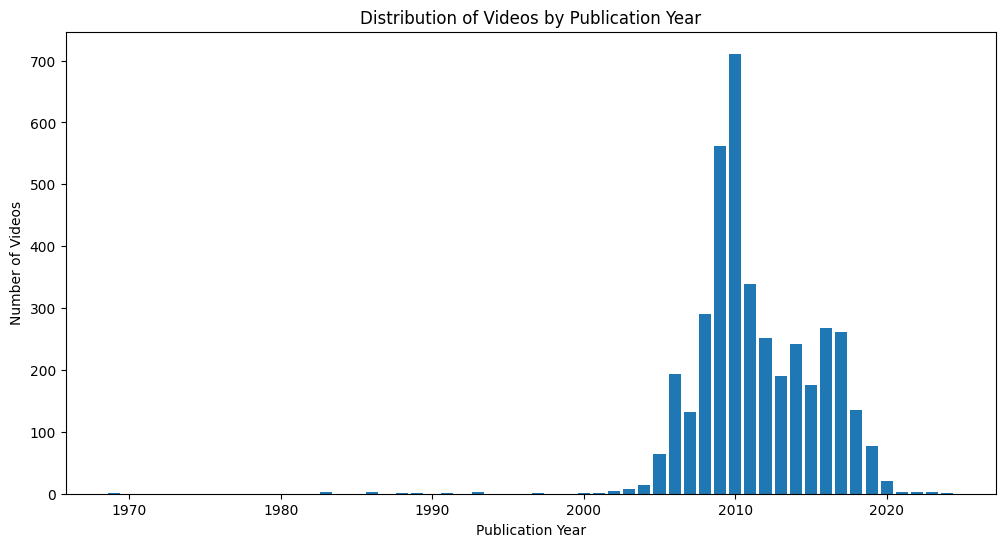

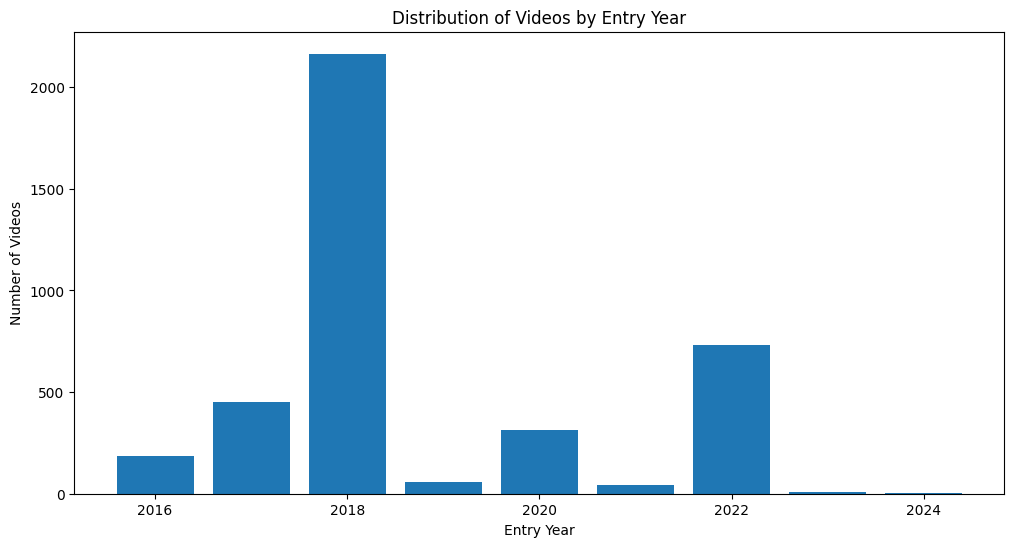

In [14]:
# Exploring publication and entry date
video_df['publication_datetime'] = pd.to_datetime(video_df['publication_date'], errors='coerce')
video_df['entry_datetime'] = pd.to_datetime(video_df['entry_date'], errors='coerce')

df_dates_for_plot = video_df.dropna(subset=['publication_datetime', 'entry_datetime'])

plt.figure(figsize=(12, 6))
plt.hist(df_dates_for_plot['publication_datetime'].dt.year, bins=range(df_dates_for_plot['publication_datetime'].dt.year.min(), df_dates_for_plot['publication_datetime'].dt.year.max() + 2), align='left', rwidth=0.8)
plt.xlabel("Publication Year")
plt.ylabel("Number of Videos")
plt.title("Distribution of Videos by Publication Year")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(df_dates_for_plot['entry_datetime'].dt.year, bins=range(df_dates_for_plot['entry_datetime'].dt.year.min(), df_dates_for_plot['entry_datetime'].dt.year.max() + 2), align='left', rwidth=0.8)
plt.xlabel("Entry Year")
plt.ylabel("Number of Videos")
plt.title("Distribution of Videos by Entry Year")
plt.show()

In [15]:
# Analyze authors and research/sponsor orgs
all_authors_list = get_flat_list_from_column(video_df['authors'])
print("\nTop 20 Most Frequent Authors:")
print(Counter(all_authors_list).most_common(20))

all_research_orgs_list = get_flat_list_from_column(video_df['research_orgs'])
print("\nTop 20 Most Frequent Research Organizations:")
print(Counter(all_research_orgs_list).most_common(20))

all_sponsor_orgs_list = get_flat_list_from_column(video_df['sponsor_orgs'])
print("\nTop 20 Most Frequent Sponsoring Organizations:")
print(Counter(all_sponsor_orgs_list).most_common(20))

all_subjects_list = get_flat_list_from_column(video_df['subjects'])
print("\nTop 50 most frequent subjects:")
print(Counter(all_subjects_list).most_common(50))


Top 20 Most Frequent Authors:
[('Lincoln, Don', 76), ('Chu, Steven', 34), ('Cody, Tom', 11), ('Isaacs, Eric', 10), ('Beckman, Pete', 10), ('Hunsberger, Maren', 9), ('Obama, Barack', 9), ("D'Agostino, Thomas", 9), ('Love, Lonnie', 8), ('Keasling, Jay', 8), ('Smith, Ray', 8), ('Oglecka, Kamila', 8), ('Rangamani, Padmini', 8), ('Liedberg, Bo', 8), ('Kraut, Rachel S', 8), ('Parikh, Atul N', 8), ('LBNL, Berkeley Lab', 7), ('Moniz, Ernest', 7), ('King, Alex', 7), ('Cowan, Glen', 7)]

Top 20 Most Frequent Research Organizations:
[('Lawrence Berkeley National Lab. (LBNL), Berkeley, CA (United States)', 470), ('Argonne National Lab. (ANL), Argonne, IL (United States)', 229), ('FNAL (Fermi National Accelerator Laboratory (FNAL), Batavia, IL (United States))', 185), ('Los Alamos National Lab. (LANL), Los Alamos, NM (United States)', 158), ('DOE Joint Genome Institute (JGI), LBNL (Lawrence Berkeley National Laboratory (LBNL), Berkeley, CA (United States))', 151), ('Oak Ridge National Lab. (ORNL),

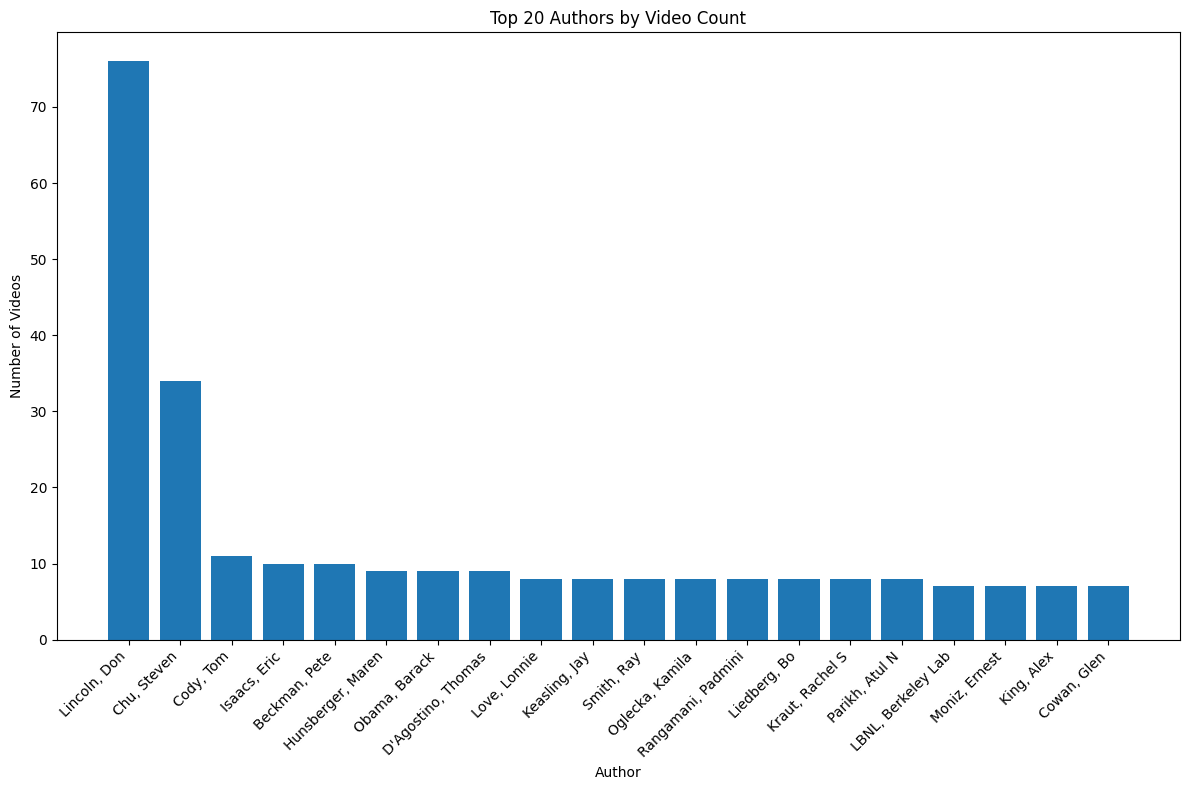

In [16]:
# Get author frequencies and visualize
author_counts = Counter(all_authors_list)
top_authors_for_plot = author_counts.most_common(20)
authors_plot, counts_plot = zip(*top_authors_for_plot)

plt.figure(figsize=(12, 8))
plt.bar(authors_plot, counts_plot)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Author")
plt.ylabel("Number of Videos")
plt.title("Top 20 Authors by Video Count")
plt.tight_layout()
plt.show()

In [17]:
# Create table data
df_table = pd.DataFrame({'Author': authors_plot, 'Video Count': counts_plot})
print("\nTop 20 Authors by Video Count (Table)")
print(df_table)


Top 20 Authors by Video Count (Table)
                Author  Video Count
0         Lincoln, Don           76
1          Chu, Steven           34
2            Cody, Tom           11
3         Isaacs, Eric           10
4        Beckman, Pete           10
5    Hunsberger, Maren            9
6        Obama, Barack            9
7   D'Agostino, Thomas            9
8         Love, Lonnie            8
9        Keasling, Jay            8
10          Smith, Ray            8
11     Oglecka, Kamila            8
12  Rangamani, Padmini            8
13        Liedberg, Bo            8
14     Kraut, Rachel S            8
15      Parikh, Atul N            8
16  LBNL, Berkeley Lab            7
17       Moniz, Ernest            7
18          King, Alex            7
19         Cowan, Glen            7


In [18]:
# Analyze subjects field
all_subjects = [subject.strip() for record in video_data for subject in record.get('subjects', [])]
print("\nTop 50 most frequent subjects:")
print(Counter(all_subjects).most_common(50))


Top 50 most frequent subjects:
[('59 BASIC BIOLOGICAL SCIENCES', 477), ('99 GENERAL AND MISCELLANEOUS', 345), ('72 PHYSICS OF ELEMENTARY PARTICLES AND FIELDS', 319), ('32 ENERGY CONSERVATION, CONSUMPTION, AND UTILIZATION', 285), ('97 MATHEMATICS AND COMPUTING', 280), ('36 MATERIALS SCIENCE', 239), ('43 PARTICLE ACCELERATORS', 230), ('79 ASTRONOMY AND ASTROPHYSICS', 223), ('54 ENVIRONMENTAL SCIENCES', 219), ('ENERGY', 219), ('29 ENERGY PLANNING, POLICY, AND ECONOMY', 181), ('42 ENGINEERING', 152), ('PHYSICS', 133), ('71 CLASSICAL AND QUANTUM MECHANICS, GENERAL PHYSICS', 126), ('25 ENERGY STORAGE', 119), ('LBNL', 115), ('LHC', 115), ('14 SOLAR ENERGY', 107), ('60 APPLIED LIFE SCIENCES', 102), ('DOE', 102), ('77 NANOSCIENCE AND NANOTECHNOLOGY', 98), ('SCIENCE', 97), ('47 OTHER INSTRUMENTATION', 93), ('RESEARCH', 90), ('ENERGY EFFICIENCY', 84), ('CERN', 83), ('CLIMATE CHANGE', 76), ('UNIVERSE', 74), ('DEPARTMENT OF ENERGY', 73), ('09 BIOMASS FUELS', 71), ('12 MANAGEMENT OF RADIOACTIVE AND

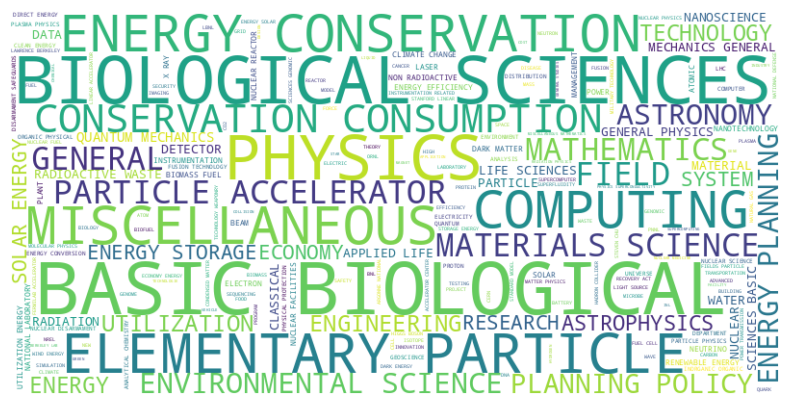

In [19]:
# Create word cloud
text_for_wordcloud = " ".join(all_subjects_list)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_for_wordcloud)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Average description length: 395.16 characters


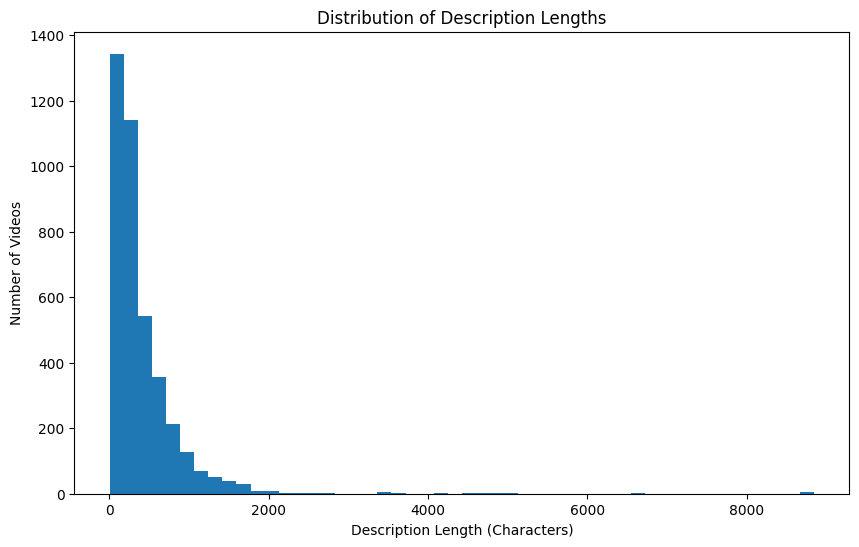

In [20]:
# Analyze description length
description_lengths = video_df['description'].apply(lambda x: len(str(x).strip()) if pd.notna(x) else 0)
print(f"\nAverage description length: {description_lengths.mean():.2f} characters")

plt.figure(figsize=(10, 6))
plt.hist(description_lengths[description_lengths > 0], bins=50) # Only plot non-zero lengths
plt.xlabel("Description Length (Characters)")
plt.ylabel("Number of Videos")
plt.title("Distribution of Description Lengths")
plt.show()

# Topic Modeling (BERTopic)

Text Preprocessing for Topic Modeling

In [21]:
# Set global random seed
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Global random seeds and deterministic flags set.")

Global random seeds and deterministic flags set.


In [22]:
# Clean and prepare data
text_column_name = 'description'
print(f"Cleaning and Preparing Data from the '{text_column_name}' column")

Cleaning and Preparing Data from the 'description' column


In [23]:
# Identify missing values
missing_descriptions_before = video_df[text_column_name].isnull().sum()
stripped_descriptions = video_df[text_column_name].apply(lambda x: str(x).strip())
missing_descriptions_before_str_nulls = stripped_descriptions.isin(['', 'none', 'nan', 'null']).sum()
total_missing_before_cleaning = missing_descriptions_before + missing_descriptions_before_str_nulls
print(f"Number of videos with missing descriptions before cleaning (NaNs + string nulls): {total_missing_before_cleaning}")

Number of videos with missing descriptions before cleaning (NaNs + string nulls): 479


In [24]:
# Remove rows with missing descriptions
original_row_count = len(video_df)
video_df.dropna(subset=[text_column_name], inplace=True)
removed_nan_count = original_row_count - len(video_df)
print(f"Removed {removed_nan_count} rows with actual NaN descriptions.")

Removed 0 rows with actual NaN descriptions.


In [25]:
# Remove rows with empty or whitespace/string-null descriptions
original_row_count_after_nan_drop = len(video_df)
video_df = video_df[~video_df[text_column_name].apply(lambda x: str(x).strip().lower() in ['', 'none', 'nan', 'null'])].copy() # .lower() for robustness
removed_empty_string_count = original_row_count_after_nan_drop - len(video_df)
print(f"Removed {removed_empty_string_count} rows with empty or whitespace/string-null descriptions.")
print(f"\nData cleaning complete. The DataFrame now has {len(video_df)} rows ready for processing.")

Removed 479 rows with empty or whitespace/string-null descriptions.

Data cleaning complete. The DataFrame now has 3482 rows ready for processing.


In [26]:
# Initialize resources
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
stop_words.add('doe')
stop_words.add('lab')
stop_words.add('laboratory')
stop_words.add('national')
stop_words.add('research')
stop_words.add('session')
stop_words.add('student')
stop_words.add('school')
stop_words.add('lecture')
stop_words.add('video')
stop_words.add('summit')
stop_words.add('held')
stop_words.add('prof')
stop_words.add('new')
stop_words.add('researcher')
stop_words.add('science')
stop_words.add('meeting')
stop_words.add('annual')
stop_words.add('march')
stop_words.add('workshop')
stop_words.add('organized')
stop_words.add('delivered')
stop_words.add('series')
stop_words.add('discussion')
stop_words.add('auditorium')
stop_words.add('february')
stop_words.add('january')
stop_words.add('salle')
stop_words.add('give')
stop_words.add('presentation')
stop_words.add('finishing')
stop_words.add('santa')
stop_words.add('june')
stop_words.add('part')
stop_words.add('speaker')
stop_words.add('discusses')
stop_words.add('jgi')
stop_words.add('argonne')
stop_words.add('berkeley')
stop_words.add('fermilab')
stop_words.add('university')
stop_words.add('center')
stop_words.add('institute')
stop_words.add('department')
stop_words.add('de')
stop_words.add('est')
stop_words.add('le')
stop_words.add('sur')
stop_words.add('quot')
stop_words.add('avec')
stop_words.add('san')
stop_words.add('la')
stop_words.add('les')
stop_words.add('des')
stop_words.add('et')
stop_words.add('en')
stop_words.add('un')
stop_words.add('une')
stop_words.add('year')
stop_words.add('site')
stop_words.add('project')
stop_words.add('act')
stop_words.add('standard')
stop_words.add('event')
stop_words.add('day')
stop_words.add('answer')
stop_words.add('speech')
stop_words.add('october')
stop_words.add('service')
stop_words.add('talk')
stop_words.add('system')
stop_words.add('scale')
stop_words.add('one')
stop_words.add('time')
stop_words.add('world')
stop_words.add('state')
stop_words.add('first')
stop_words.add('winter')
stop_words.add('study')
stop_words.add('meeting')
stop_words.add('pour')
stop_words.add('dans')
stop_words.add('son')
stop_words.add('par')
stop_words.add('user')
stop_words.add('use')
stop_words.add('used')
stop_words.add('using')
stop_words.add('give')
stop_words.add('talk')
stop_words.add('adam')
stop_words.add('george')
stop_words.add('smoot')
stop_words.add('qui')
stop_words.add('parle')
stop_words.add('conference')
stop_words.add('professor')
stop_words.add('help')
stop_words.add('give')
stop_words.add('director')
stop_words.add('provide')
stop_words.add('able')
stop_words.add('many')
stop_words.add('toward')
stop_words.add('main')
stop_words.add('one')
stop_words.add('discours')
stop_words.add('question')
stop_words.add('show')
stop_words.add('known')
stop_words.add('point')
stop_words.add('plusieurs')
stop_words.add('sentation')
stop_words.add('office')
stop_words.add('etc')

print("Lemmatizer and stop words set have been created.")

Lemmatizer and stop words set have been created.


In [27]:
# Define the preprocessing Function
def preprocess_text(text):
    if not isinstance(text, str):
        return []

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]+', ' ', text)

    word_tokens = word_tokenize(text)

    lemmatized_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in word_tokens
        if word.lower() not in stop_words and len(word) > 2
    ]

    return lemmatized_tokens

print("Function preprocess_text is now defined.")

Function preprocess_text is now defined.


In [28]:
# Apply the function
text_column_name = 'description'
print(f"Applying text preprocessing to the '{text_column_name}' column")

if text_column_name in video_df.columns:
    video_df['processed_tokens'] = video_df[text_column_name].apply(preprocess_text)

    print("New column 'processed_tokens' has been added to 'video_df'.")
else:
    print(f"ERROR: A column named '{text_column_name}' was not found in 'video_df'.")

Applying text preprocessing to the 'description' column
New column 'processed_tokens' has been added to 'video_df'.


In [29]:
# Text cleaning
video_df_filtered = video_df.copy()

video_df['authors'] = video_df['authors'].astype(str)
video_df_filtered['osti_id'] = video_df_filtered['osti_id'].astype(str).str.strip().str.lower()
video_df_filtered['description'] = video_df_filtered['description'].astype(str)
video_df_filtered['title'] = video_df_filtered['title'].astype(str)
video_df_filtered['publication_date'] = video_df_filtered['publication_date'].astype(str)

def clean_raw_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

video_df_filtered['cleaned_description_bertopic'] = video_df_filtered['description'].apply(clean_raw_text)
video_df_filtered['authors'] = video_df_filtered['authors'].astype(str)

docs = video_df_filtered['cleaned_description_bertopic'].tolist()

print(f"Number of documents for BERTopic: {len(docs)}")

Number of documents for BERTopic: 3482


BERTopic Model

In [30]:
# Initialize and train BERTopic Model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
representation_model = KeyBERTInspired(top_n_words=15)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
    embedding_model=embedding_model,
    representation_model=representation_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=20,
    min_topic_size=15,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs)

2025-06-12 14:42:35,309 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2025-06-12 14:45:18,218 - BERTopic - Embedding - Completed ✓
2025-06-12 14:45:18,220 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-12 14:45:56,822 - BERTopic - Dimensionality - Completed ✓
2025-06-12 14:45:56,824 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-12 14:45:56,982 - BERTopic - Cluster - Completed ✓
2025-06-12 14:45:56,983 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-12 14:45:57,370 - BERTopic - Representation - Completed ✓
2025-06-12 14:45:57,375 - BERTopic - Topic reduction - Reducing number of topics
2025-06-12 14:45:57,425 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-12 14:46:10,570 - BERTopic - Representation - Completed ✓
2025-06-12 14:46:10,575 - BERTopic - Topic reduction - Reduced number of topics from 153 to 20


In [31]:
# Explore topic information
topic_info = topic_model.get_topic_info()
print("\nBERTopic Topic Information")
print(topic_info)


BERTopic Topic Information
    Topic  Count                                               Name  \
0      -1    836   -1_scientist_scientists_researchers_technologies   
1       0    835                      0_cern_lhc_cosmology_collider   
2       1    490                      1_hpc_technologies_efrc_efrcs   
3       2    351             2_genomics_genomic_genome_metagenomics   
4       3    300                   3_summit_energy_innovation_arpae   
5       4    186         4_nanomaterials_nanoscale_materials_metals   
6       5    122               5_scientifique_une_département_entre   
7       6     76       6_climate_warming_weatherization_atmospheric   
8       7     70                      7_savannah_river_missions_srs   
9       8     44               8_cells_cell_nucleus_heterochromatin   
10      9     39                9_robotics_microrobots_robot_robots   
11     10     26  10_cybersecurity_cybercrime_cyberattacks_cyber...   
12     11     23           11_biotechnology_labor

# Topic Prevalence Analysis

In [32]:
# Get top words for each reduced topic
print("\nBERTopic Top Words per Topic, based on c-TF-IDF")
for topic_id in topic_model.get_topics():
    if topic_id == -1:
        print(f"\nTopic {topic_id} (Outliers): Documents that don't fit well into any topic.")
    else:
        words_with_scores = topic_model.get_topic(topic_id)
        print(f"\nTopic {topic_id} ({topic_model.get_topic_info(topic_id)['Name']}):")
        if words_with_scores:
            for word, score in words_with_scores[:15]:
                print(f"  {word}: {score:.4f}")
        else:
            print("  (No words extracted for this topic)")


BERTopic Top Words per Topic, based on c-TF-IDF

Topic -1 (Outliers): Documents that don't fit well into any topic.

Topic 0 (0    0_cern_lhc_cosmology_collider
Name: Name, dtype: object):
  cern: 0.5381
  lhc: 0.4379
  cosmology: 0.4376
  collider: 0.3958
  universe: 0.3617
  neutrinos: 0.3459
  fermilabs: 0.3376
  neutrino: 0.3252
  particles: 0.3163
  matter: 0.3020
  fermilab: 0.2996
  facility: 0.2894
  scientists: 0.2890
  physics: 0.2757
  particle: 0.2693

Topic 1 (0    1_hpc_technologies_efrc_efrcs
Name: Name, dtype: object):
  hpc: 0.4304
  technologies: 0.3514
  efrc: 0.3496
  efrcs: 0.3441
  computing: 0.3299
  grid: 0.3135
  applications: 0.3103
  finance: 0.2970
  technology: 0.2898
  financial: 0.2811
  ubs: 0.2703
  energys: 0.2580
  solar: 0.2539
  centers: 0.2502
  future: 0.2482

Topic 2 (0    2_genomics_genomic_genome_metagenomics
Name: Name, dtype: object):
  genomics: 0.5644
  genomic: 0.5524
  genome: 0.5451
  metagenomics: 0.5430
  genomes: 0.5332
  consortium:

In [33]:
# Evaluate assignments
print("\nBERTopic Representative Documents for Each Topic")
for topic_id in topic_model.get_topics():
    if topic_id == -1: continue

    representative_doc_strings = topic_model.get_representative_docs(topic_id)

    if representative_doc_strings:
        original_indices = [docs.index(doc_str) for doc_str in representative_doc_strings]

        representative_docs_df = video_df_filtered.iloc[original_indices]

        print(f"\nTopic {topic_id} ({topic_model.get_topic_info(topic_id)['Name']}):")
        for idx, row in representative_docs_df.iterrows():
            print(f"  OSTI ID: {row['osti_id']}")
            print(f"  Title: {row['title']}")
            print(f"  Description (first 200 chars): {str(row['description'])[:200]}...")
            print("-" * 20)
    else:
        print(f"\nTopic {topic_id} ({topic_model.get_topic_info(topic_id)['Name']}): No representative documents found.")


BERTopic Representative Documents for Each Topic

Topic 0 (0    0_cern_lhc_cosmology_collider
Name: Name, dtype: object):
  OSTI ID: 1026335
  Title: COSMO 09
  Description (first 200 chars): This year's edition of the annual Cosmo International Conference on Particle Physics and Cosmology -- Cosmo09 -- will be hosted by  the CERN Theory Group from Monday September 7 till Friday September ...
--------------------
  OSTI ID: 1026203
  Title: CERN Winter School on Supergravity, Strings, and Gauge Theory 2010
  Description (first 200 chars): The CERN Winter School on Supergravity, Strings, and Gauge Theory is the analytic continuation of the yearly training school of the former EC-RTN string network "Constituents, Fundamental Forces and S...
--------------------
  OSTI ID: 1026338
  Title: COSMO 09
  Description (first 200 chars): Part 5 lecture. Outline 1) Evidence for primary cosmic ray positrons 2) DM species with quite special properties 3) The effect of clumpiness on DM annihilaion 

In [34]:
# Generate document embeddings
document_embeddings = embedding_model.encode(docs, show_progress_bar=True)
print(f"Shape of generated document embeddings: {document_embeddings.shape}")

np.save('document_embeddings.npy', document_embeddings)
np.save('video_df_filtered_indices.npy', video_df_filtered.index.to_numpy())
print("Document embeddings and corresponding indices saved successfully.")

print(f"video_df_filtered columns before reset: {video_df_filtered.columns.tolist()}")
print(f"video_df_filtered head before reset:\n{video_df_filtered.head()}")
print(f"Length of video_df_filtered: {len(video_df_filtered)}")
print(f"Length of topics list: {len(topics)}")

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

Shape of generated document embeddings: (3482, 384)
Document embeddings and corresponding indices saved successfully.
video_df_filtered columns before reset: ['osti_id', 'title', 'product_type', 'language', 'country_publication', 'description', 'publication_date', 'entry_date', 'format', 'mime_type', 'authors', 'subjects', 'sponsor_orgs', 'research_orgs', 'links', 'media_duration', 'availability', 'publisher', 'doe_contract_number', 'report_number', 'doi', 'journal_issue', 'journal_volume', 'publication_datetime', 'entry_datetime', 'processed_tokens', 'cleaned_description_bertopic']
video_df_filtered head before reset:
   osti_id                                              title product_type  \
0  2320255  Materials for the Photoluminescence-Based Dete...   Multimedia   
1  1052825  Talking the Higgs Boson with Dr. Joseph Incand...   Multimedia   
2  1986275  Building the Case for Hybrid Energy Developmen...   Multimedia   
3  1986274  Building the Case for Hybrid Energy Developmen...

In [35]:
# Re-set dataframe
video_df_filtered = video_df_filtered.reset_index(drop=True).copy()
print(f"video_df_filtered columns after reset: {video_df_filtered.columns.tolist()}")
print(f"video_df_filtered head after reset:\n{video_df_filtered.head()}")
print(f"Length of video_df_filtered after reset: {len(video_df_filtered)}")

video_df_filtered columns after reset: ['osti_id', 'title', 'product_type', 'language', 'country_publication', 'description', 'publication_date', 'entry_date', 'format', 'mime_type', 'authors', 'subjects', 'sponsor_orgs', 'research_orgs', 'links', 'media_duration', 'availability', 'publisher', 'doe_contract_number', 'report_number', 'doi', 'journal_issue', 'journal_volume', 'publication_datetime', 'entry_datetime', 'processed_tokens', 'cleaned_description_bertopic']
video_df_filtered head after reset:
   osti_id                                              title product_type  \
0  2320255  Materials for the Photoluminescence-Based Dete...   Multimedia   
1  1052825  Talking the Higgs Boson with Dr. Joseph Incand...   Multimedia   
2  1986275  Building the Case for Hybrid Energy Developmen...   Multimedia   
3  1986274  Building the Case for Hybrid Energy Developmen...   Multimedia   
4  1025939                     The state of the Java universe   Multimedia   

  language country_publi

In [36]:
# Embedding assignment
video_df_filtered.loc[:, 'embedding'] = pd.Series(document_embeddings.tolist(), index=video_df_filtered.index)
print(" 'embedding' column assigned.")
print(f"video_df_filtered columns after embedding: {video_df_filtered.columns.tolist()}")
print(f"video_df_filtered head after embedding:\n{video_df_filtered.head()}")

 'embedding' column assigned.
video_df_filtered columns after embedding: ['osti_id', 'title', 'product_type', 'language', 'country_publication', 'description', 'publication_date', 'entry_date', 'format', 'mime_type', 'authors', 'subjects', 'sponsor_orgs', 'research_orgs', 'links', 'media_duration', 'availability', 'publisher', 'doe_contract_number', 'report_number', 'doi', 'journal_issue', 'journal_volume', 'publication_datetime', 'entry_datetime', 'processed_tokens', 'cleaned_description_bertopic', 'embedding']
video_df_filtered head after embedding:
   osti_id                                              title product_type  \
0  2320255  Materials for the Photoluminescence-Based Dete...   Multimedia   
1  1052825  Talking the Higgs Boson with Dr. Joseph Incand...   Multimedia   
2  1986275  Building the Case for Hybrid Energy Developmen...   Multimedia   
3  1986274  Building the Case for Hybrid Energy Developmen...   Multimedia   
4  1025939                     The state of the Java

In [37]:
# Assign BERTopic ID
video_df_filtered.loc[:, 'bertopic_topic_id'] = topics
print(" 'bertopic_topic_id' column assigned.")
print(f"video_df_filtered columns after topic_id: {video_df_filtered.columns.tolist()}")
print(f"video_df_filtered head after topic_id:\n{video_df_filtered.head()}")

 'bertopic_topic_id' column assigned.
video_df_filtered columns after topic_id: ['osti_id', 'title', 'product_type', 'language', 'country_publication', 'description', 'publication_date', 'entry_date', 'format', 'mime_type', 'authors', 'subjects', 'sponsor_orgs', 'research_orgs', 'links', 'media_duration', 'availability', 'publisher', 'doe_contract_number', 'report_number', 'doi', 'journal_issue', 'journal_volume', 'publication_datetime', 'entry_datetime', 'processed_tokens', 'cleaned_description_bertopic', 'embedding', 'bertopic_topic_id']
video_df_filtered head after topic_id:
   osti_id                                              title product_type  \
0  2320255  Materials for the Photoluminescence-Based Dete...   Multimedia   
1  1052825  Talking the Higgs Boson with Dr. Joseph Incand...   Multimedia   
2  1986275  Building the Case for Hybrid Energy Developmen...   Multimedia   
3  1986274  Building the Case for Hybrid Energy Developmen...   Multimedia   
4  1025939               

In [38]:
# Define the canonicalize name function
def canonicalize_name(name_str):
    if not isinstance(name_str, str):
        return str(name_str)
    name_str = name_str.strip()
    name_str = unicodedata.normalize('NFKC', name_str)
    name_str = "".join(ch for ch in name_str if unicodedata.category(ch)[0]!="C")
    return name_str

In [39]:
# Define new topic names
new_topic_names_raw = {
    0: "CERN & Particle Physics",
    1: "HPC & EFRC Technologies",
    2: "Genomics & Metagenomics",
    3: "Energy Innovation & Policy Summits",
    4: "Nanotech & Materials Science",
    5: "French Scientific Outreach",
    6: "Climate Change & Atmospheric Science",
    7: "Savannah River Site Ops",
    8: "Cellular & Molecular Biology",
    9: "Robotics",
    10: "Cybersecurity",
    11: "Virtual Labs & Biotechnology",
    12: "Neurodegenerative Diseases",
    13: "Relativity & Fundamental Physics",
    14: "Cosmology",
    15: "Earthquake & Seismology",
    16: "Medical Flow Visualization",
    17: "Fluorescence & Biophysics",
    18: "Hydroelectric Power & Dams",

    # Outlier Topic
    -1: "Outlier / General Content"
}

new_topic_names = {k: canonicalize_name(v) for k, v in new_topic_names_raw.items()}

In [40]:
# Apply custom topic names
topic_model.set_topic_labels(new_topic_names)
print("\nCanonicalized topic names applied to BERTopic model.")


Canonicalized topic names applied to BERTopic model.


In [41]:
# Assign new topic names
video_df_filtered.loc[:, 'bertopic_topic_name'] = video_df_filtered['bertopic_topic_id'].map(new_topic_names)
print(" 'bertopic_topic_name' column assigned.")
print(video_df_filtered[['title', 'bertopic_topic_name', 'embedding']].head())

 'bertopic_topic_name' column assigned.
                                               title  \
0  Materials for the Photoluminescence-Based Dete...   
1  Talking the Higgs Boson with Dr. Joseph Incand...   
2  Building the Case for Hybrid Energy Developmen...   
3  Building the Case for Hybrid Energy Developmen...   
4                     The state of the Java universe   

            bertopic_topic_name  \
0  Nanotech & Materials Science   
1     Outlier / General Content   
2       HPC & EFRC Technologies   
3       HPC & EFRC Technologies   
4       HPC & EFRC Technologies   

                                           embedding  
0  [-0.06512309610843658, -0.02097429148852825, 0...  
1  [-0.1550673097372055, 0.01007034070789814, 0.0...  
2  [-0.044683899730443954, 0.05238332599401474, -...  
3  [-0.04282555356621742, 0.050655972212553024, -...  
4  [-0.07771943509578705, 0.031315285712480545, -...  


Visualize Topic Prevalence

In [42]:
# Dataframe for Topics
topic_info_df = topic_model.get_topic_info()
topic_info_df = topic_info_df[topic_info_df['Topic'] != -1]
topic_info_df.loc[:, 'CustomName'] = topic_info_df['Topic'].map(new_topic_names)
topic_info_df = topic_info_df.sort_values(by='Count', ascending=False)

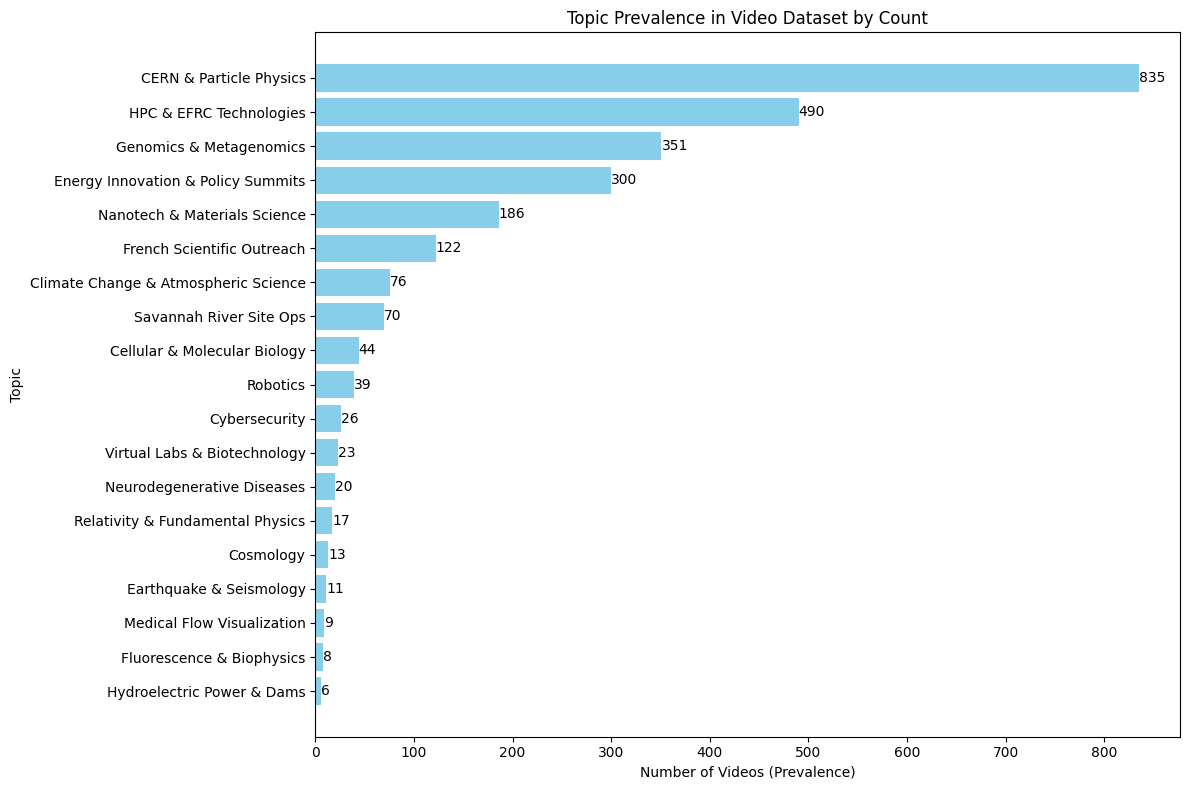


Topic Prevalence by Custom Name
Topic 0 (CERN & Particle Physics): 835 documents
Topic 1 (HPC & EFRC Technologies): 490 documents
Topic 2 (Genomics & Metagenomics): 351 documents
Topic 3 (Energy Innovation & Policy Summits): 300 documents
Topic 4 (Nanotech & Materials Science): 186 documents
Topic 5 (French Scientific Outreach): 122 documents
Topic 6 (Climate Change & Atmospheric Science): 76 documents
Topic 7 (Savannah River Site Ops): 70 documents
Topic 8 (Cellular & Molecular Biology): 44 documents
Topic 9 (Robotics): 39 documents
Topic 10 (Cybersecurity): 26 documents
Topic 11 (Virtual Labs & Biotechnology): 23 documents
Topic 12 (Neurodegenerative Diseases): 20 documents
Topic 13 (Relativity & Fundamental Physics): 17 documents
Topic 14 (Cosmology): 13 documents
Topic 15 (Earthquake & Seismology): 11 documents
Topic 16 (Medical Flow Visualization): 9 documents
Topic 17 (Fluorescence & Biophysics): 8 documents
Topic 18 (Hydroelectric Power & Dams): 6 documents


In [43]:
# Create visualization
plt.figure(figsize=(12, 8))
bars = plt.barh(topic_info_df['CustomName'], topic_info_df['Count'], color='skyblue')

plt.xlabel("Number of Videos (Prevalence)")
plt.ylabel("Topic")
plt.title("Topic Prevalence in Video Dataset by Count")
plt.gca().invert_yaxis()
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}',
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()

print("\nTopic Prevalence by Custom Name")
for index, row in topic_info_df.iterrows():
    print(f"Topic {row['Topic']} ({row['CustomName']}): {row['Count']} documents")

# Temporal Trend Analysis

In [44]:
# Data prep for temporal trend analysis
video_df_filtered['publication_datetime'] = pd.to_datetime(video_df_filtered['publication_date'], errors='coerce')
video_df_filtered['publication_year'] = video_df_filtered['publication_datetime'].dt.year
temporal_df = video_df_filtered.dropna(subset=['publication_year', 'bertopic_topic_name']).copy()
temporal_df = temporal_df[temporal_df['bertopic_topic_id'] != -1]
temporal_df['publication_year'] = temporal_df['publication_year'].astype(int)
topic_trends = temporal_df.groupby(['publication_year', 'bertopic_topic_name']).size().unstack(fill_value=0)

all_20_topic_names = [name for id, name in new_topic_names.items() if id != -1]
topic_trends = topic_trends.reindex(columns=all_20_topic_names, fill_value=0)


topic_trends['Annual_Total'] = topic_trends.sum(axis=1)
topic_trends_proportion = topic_trends.div(topic_trends['Annual_Total'], axis=0)
topic_trends_proportion = topic_trends_proportion.drop(columns='Annual_Total')

print("\nData preparation for temporal trends complete. Head of topic_trends (counts):")
print(topic_trends.head())
print("\nHead of topic_trends_proportion:")
print(topic_trends_proportion.head())


Data preparation for temporal trends complete. Head of topic_trends (counts):
bertopic_topic_name  CERN & Particle Physics  HPC & EFRC Technologies  \
publication_year                                                        
1983                                       2                        0   
1986                                       2                        0   
1988                                       0                        0   
1989                                       1                        0   
1993                                       1                        0   

bertopic_topic_name  Genomics & Metagenomics  \
publication_year                               
1983                                       0   
1986                                       0   
1988                                       0   
1989                                       0   
1993                                       0   

bertopic_topic_name  Energy Innovation & Policy Summits  \
publication_y

In [45]:
# Check shape
print(f"Shape of topic_trends: {topic_trends.shape}")
print(f"Number of columns in topic_trends: {topic_trends.shape[1]}")

Shape of topic_trends: (28, 20)
Number of columns in topic_trends: 20


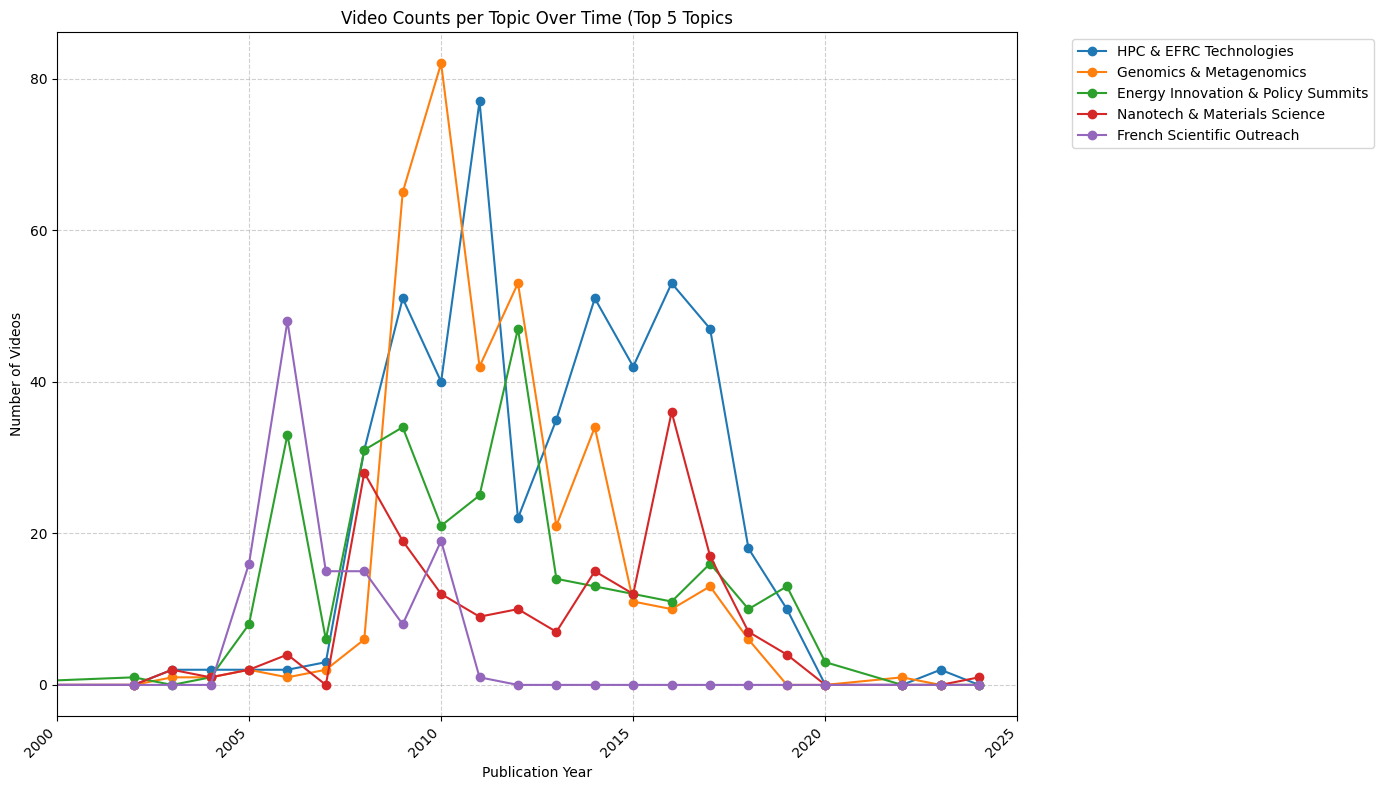

In [46]:
# Plot temporal trends
sorted_topic_info = topic_model.get_topic_info().sort_values('Count', ascending=False)
prominent_topic_ids = sorted_topic_info['Topic'].tolist()

if -1 in prominent_topic_ids:
    prominent_topic_ids.remove(-1)
if 0 in prominent_topic_ids:
    prominent_topic_ids.remove(0)

prominent_topics_for_plot = [new_topic_names.get(tid, f"Unknown Topic {tid}") for tid in prominent_topic_ids]
num_topics_for_line_plot = 5

plt.figure(figsize=(14, 8))
plotted_any_line = False

for topic_name in prominent_topics_for_plot[:num_topics_for_line_plot]:
    if topic_name in topic_trends.columns:
        if topic_trends[topic_name].sum() > 0:
            plt.plot(topic_trends.index, topic_trends[topic_name], marker='o', label=topic_name)
            plotted_any_line = True
        else:
            print(f"  Warning: Topic '{topic_name}' has all zero counts. Skipping its line plot.")
    else:
        print(f"  ERROR : Topic '{topic_name}' not found in topic_trends.columns. Check new_topic_names.")


if not plotted_any_line:
    print("\nNo lines were plotted. All selected topics might have zero counts or an issue with the index/data.")

plt.title(f"Video Counts per Topic Over Time (Top {num_topics_for_line_plot} Topics")
plt.xlabel("Publication Year")
plt.ylabel("Number of Videos")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.xlim(2000, topic_trends.index.max() + 1)
plt.tight_layout()
plt.show()

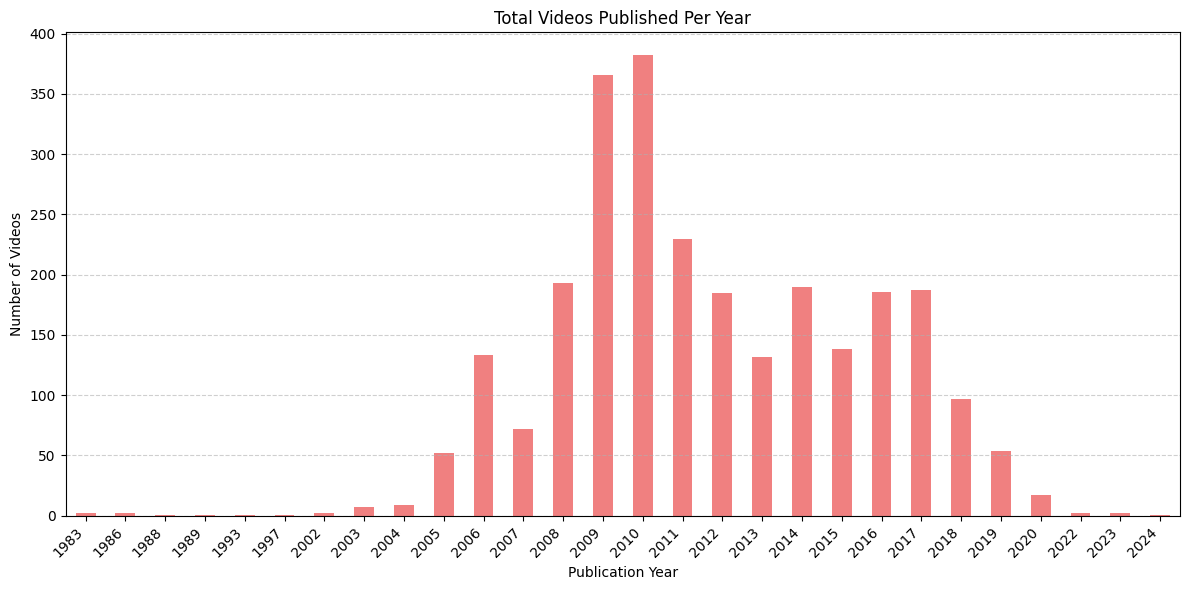

Temporal trend visualizations (Line Plots) generated.


In [47]:
# Total videos per year
plt.figure(figsize=(12, 6))
if 'Annual_Total' in topic_trends.columns:
    topic_trends['Annual_Total'].plot(kind='bar', color='lightcoral')
    plt.title("Total Videos Published Per Year")
    plt.xlabel("Publication Year")
    plt.ylabel("Number of Videos")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'Annual_Total' column not found in topic_trends. Cannot plot total videos per year.")

print("Temporal trend visualizations (Line Plots) generated.")

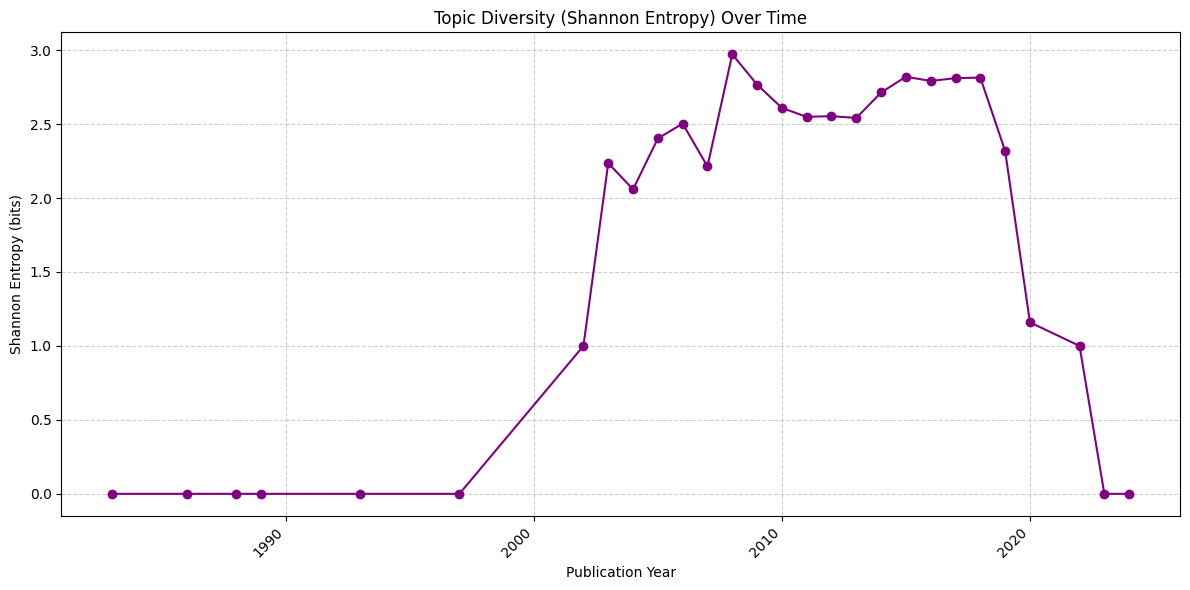


Topic diversity visualization generated.


In [48]:
# Calculate and visualize diversity metric
diversity_df = topic_trends_proportion.copy()
diversity_df = diversity_df.fillna(0)

epsilon = 1e-9
shannon_entropy_per_year = diversity_df.apply(
    lambda row: -np.sum([p * np.log2(p + epsilon) for p in row if p > 0]), axis=1
)

plt.figure(figsize=(12, 6))
shannon_entropy_per_year.plot(kind='line', marker='o', color='purple')
plt.title("Topic Diversity (Shannon Entropy) Over Time")
plt.xlabel("Publication Year")
plt.ylabel("Shannon Entropy (bits)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nTopic diversity visualization generated.")

# Temporal Trend Analysis Key Clusters

Topic Evolution Within Key Clusters

In [93]:
# Cluster topics
topic_clusters = {
    "Physics & Cosmology": [
        "CERN & Particle Physics",
        "Relativity & Fundamental Physics",
        "Cosmology",
        "Earthquake & Seismology",
    ],
    "Energy & Climate": [
        "HPC & EFRC Technologies",
        "Energy Innovation & Policy Summits",
        "Nanotech & Materials Science",
        "Hydroelectric Power & Dams",
        "Climate Change & Atmospheric Science",
    ],
    "Biosciences & Health": [
        "Genomics & Metagenomics",
        "Cellular & Molecular Biology",
        "Virtual Labs & Biotechnology",
        "Fluorescence & Biophysics",
        "Neurodegenerative Diseases",
        "Medical Flow Visualization",
    ],
    "Applied Computing & Security": [
        "Cybersecurity",
        "Robotics",
    ],
    "Lab Operations & Outreach": [
        "Savannah River Site Ops",
        "French Scientific Outreach"
    ]
}

In [94]:
# Aggregate counts by cluster
cluster_trends_counts = pd.DataFrame(index=topic_trends.index)
for cluster_name, topics_in_cluster in topic_clusters.items():
    existing_topics_in_cluster = [t for t in topics_in_cluster if t in topic_trends.columns]
    if existing_topics_in_cluster:
        cluster_trends_counts[cluster_name] = topic_trends[existing_topics_in_cluster].sum(axis=1)
    else:
        cluster_trends_counts[cluster_name] = 0

In [95]:
# Aggregate proportions
cluster_trends_proportions = pd.DataFrame(index=topic_trends_proportion.index)
for cluster_name, topics_in_cluster in topic_clusters.items():
    existing_topics_in_cluster = [t for t in topics_in_cluster if t in topic_trends_proportion.columns]
    if existing_topics_in_cluster:
        cluster_trends_proportions[cluster_name] = topic_trends_proportion[existing_topics_in_cluster].sum(axis=1)
    else:
        cluster_trends_proportions[cluster_name] = 0

print("\nCluster trends aggregated.")
print(cluster_trends_counts.head())


Cluster trends aggregated.
                  Physics & Cosmology  Energy & Climate  Biosciences & Health  \
publication_year                                                                
1983                                2                 0                     0   
1986                                2                 0                     0   
1988                                0                 1                     0   
1989                                1                 0                     0   
1993                                1                 0                     0   

                  Applied Computing & Security  Lab Operations & Outreach  
publication_year                                                           
1983                                         0                          0  
1986                                         0                          0  
1988                                         0                          0  
1989                    

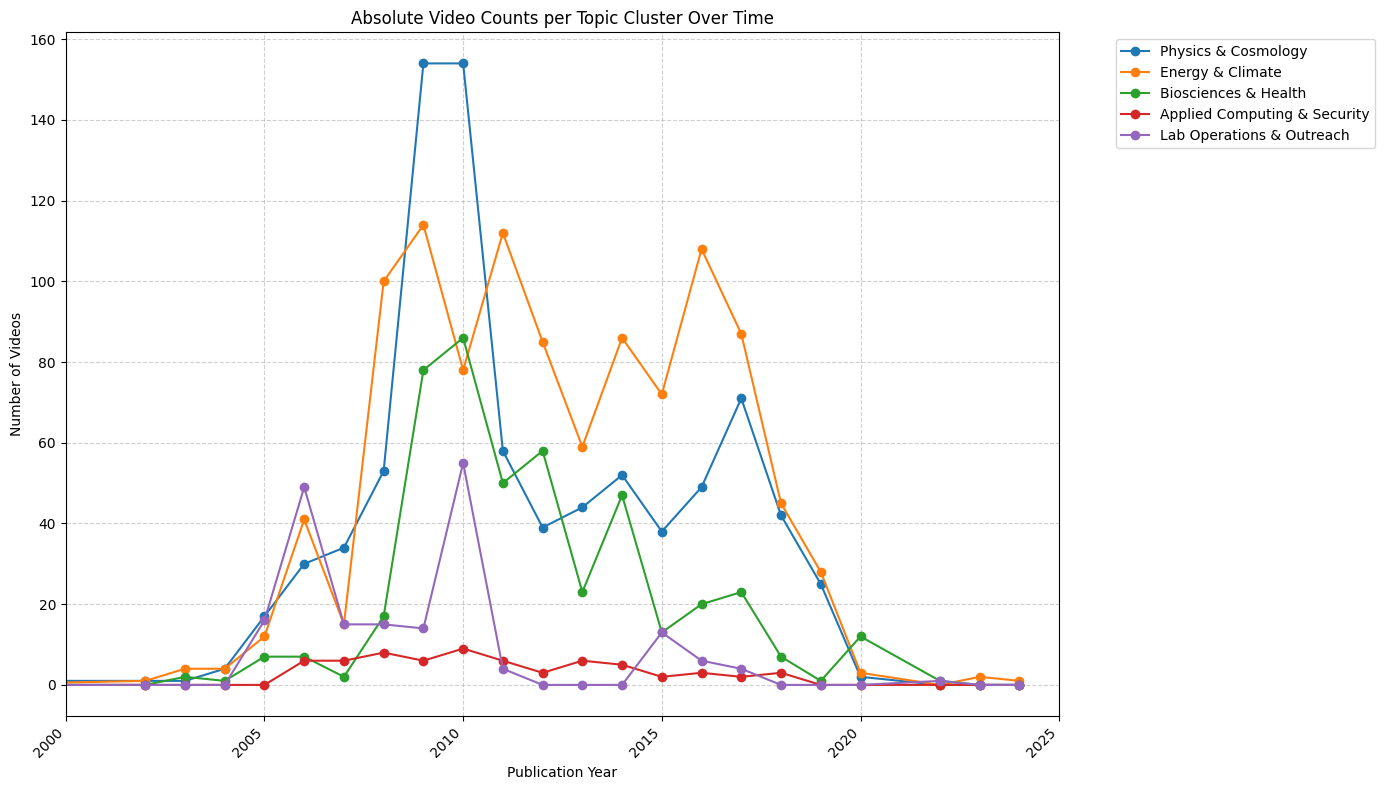

In [96]:
# Visualize video count per cluster
plt.figure(figsize=(14, 8))
for column in cluster_trends_counts.columns:
    if cluster_trends_counts[column].sum() > 0:
        plt.plot(cluster_trends_counts.index, cluster_trends_counts[column], marker='o', label=column)

plt.title("Absolute Video Counts per Topic Cluster Over Time")
plt.xlabel("Publication Year")
plt.ylabel("Number of Videos")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.xlim(2000, topic_trends.index.max() + 1)
plt.tight_layout()
plt.show()

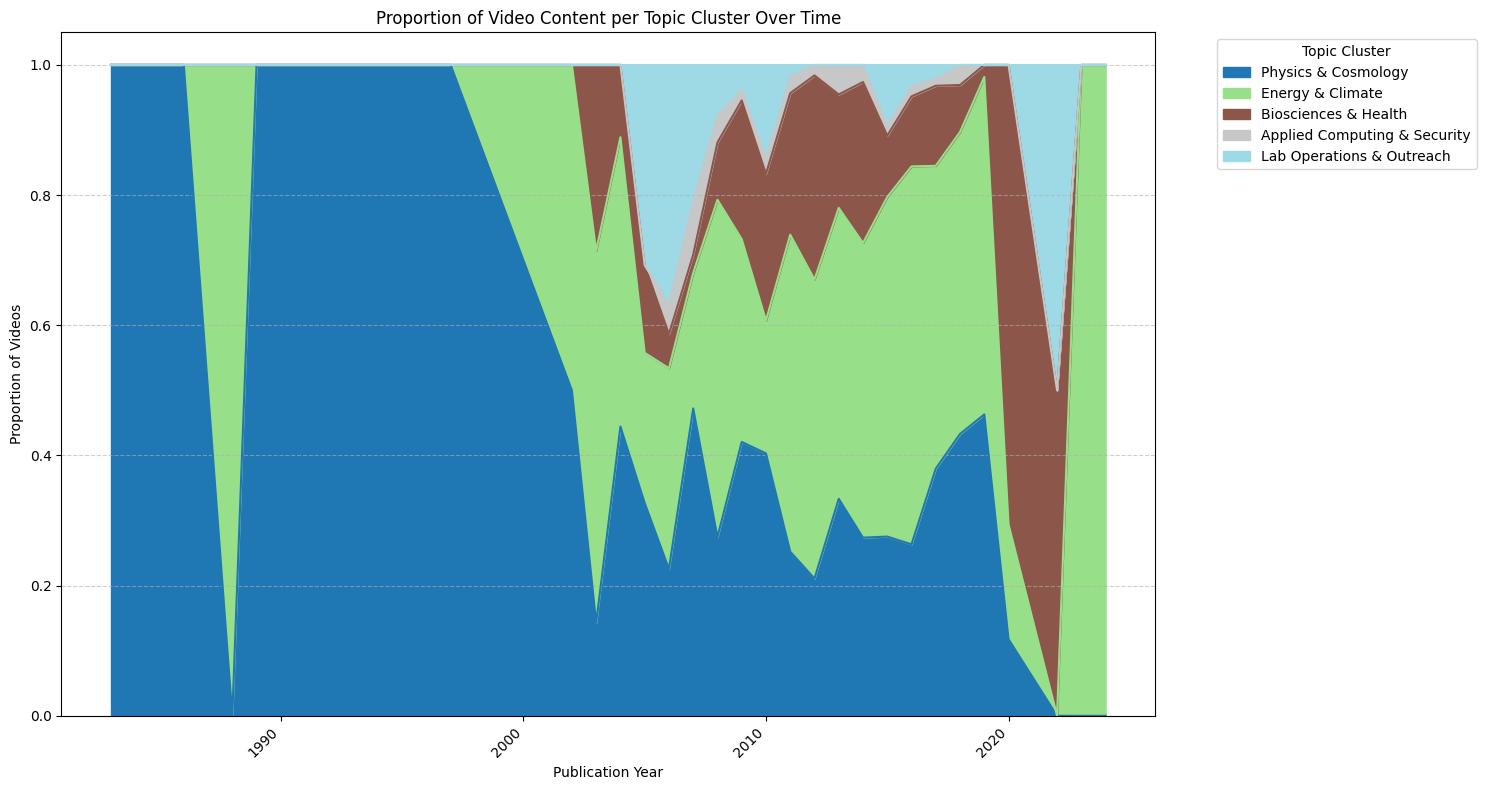


Topic cluster evolution visualization.


In [97]:
# Visualize proportional trends
ax = cluster_trends_proportions.plot(kind='area', stacked=True, figsize=(15, 8), colormap='tab20')

plt.title("Proportion of Video Content per Topic Cluster Over Time")
plt.xlabel("Publication Year")
plt.ylabel("Proportion of Videos")
plt.legend(title="Topic Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nTopic cluster evolution visualization.")

# Inter-Topic Analysis

In [54]:
# Prepare data for author-topic analysis
def _parse_single_authors_entry_final(single_authors_data):
    s_authors_data = str(single_authors_data).strip()
    if not s_authors_data or s_authors_data == 'None' or s_authors_data == 'nan' or s_authors_data == '[]':
        return []

    if ';' in s_authors_data:
        return [author.strip() for author in s_authors_data.split(';') if author.strip()]
    elif ',' in s_authors_data and not any(char.isalpha() for char in s_authors_data.split(',')[0] if char != ' '):
        return [author.strip() for author in s_authors_data.split(',') if author.strip()]

    try:
        evaluated_data = ast.literal_eval(s_authors_data)

        if isinstance(evaluated_data, list):
            names = []
            for item in evaluated_data:
                if isinstance(item, dict) and 'name' in item and str(item.get('name', '')).strip():
                    names.append(str(item['name']).strip())
                elif isinstance(item, str) and item.strip():
                    names.append(item.strip())
            return names

        elif isinstance(evaluated_data, dict) and 'name' in evaluated_data:
            name_str = str(evaluated_data.get('name', '')).strip()
            if name_str: return [name_str]
            else: return []

        else:
            return []

    except (ValueError, SyntaxError, TypeError):
        return [s_authors_data]

def parse_authors_simplified(authors_data_input):
    return _parse_single_authors_entry_final(authors_data_input)

author_topic_data = []

df_for_network = video_df_filtered[video_df_filtered['bertopic_topic_id'] != -1].copy()
df_for_network['authors_processed_list'] = df_for_network['authors'].apply(parse_authors_simplified)

In [55]:
# Create author-topic mapping
for index, row in df_for_network.iterrows():
    topic_id = row['bertopic_topic_id']
    video_id = row['osti_id']

    authors_in_row = row['authors_processed_list']

    if authors_in_row:
        for author in authors_in_row:
            author_topic_data.append({
                'author': author,
                'topic_id': topic_id,
                'topic_name': topic_name,
                'video_id': video_id
            })
author_topic_df = pd.DataFrame(author_topic_data)
author_topic_df = author_topic_df[~author_topic_df['author'].isin(['N/A', 'Unknown', '', None])]

print(f"\nAuthor-Topic mapping created. Total entries: {len(author_topic_df)}")
print(author_topic_df.head())


Author-Topic mapping created. Total entries: 3282
                                              author  topic_id  \
0                             Crawford, Scott [NETL]         4   
1  Kim, Ki-Joong [NETL Site Support Contractor, N...         4   
2  Ellis, James [NETL Site Support Contractor, Na...         4   
3  Diemler, Nathan [NETL Site Support Contractor,...         4   
4                               Baltrus, John [NETL]         4   

                   topic_name video_id  
0  French Scientific Outreach  2320255  
1  French Scientific Outreach  2320255  
2  French Scientific Outreach  2320255  
3  French Scientific Outreach  2320255  
4  French Scientific Outreach  2320255  


In [56]:
# Build topic-topic adjacency matrix
unique_topic_ids_for_network = author_topic_df['topic_id'].unique().tolist()
unique_topic_ids_for_network.sort()

adj_matrix = pd.DataFrame(0, index=unique_topic_ids_for_network, columns=unique_topic_ids_for_network, dtype=int)
authors_unique_topic_ids = author_topic_df.groupby('author')['topic_id'].apply(lambda x: list(set(x)))

for author, unique_topic_ids_list_for_author in authors_unique_topic_ids.items():
    if len(unique_topic_ids_list_for_author) > 1:
        for i in range(len(unique_topic_ids_list_for_author)):
            for j in range(i + 1, len(unique_topic_ids_list_for_author)):
                topic_a_id = unique_topic_ids_list_for_author[i]
                topic_b_id = unique_topic_ids_list_for_author[j]

                adj_matrix.loc[topic_a_id, topic_b_id] += 1
                adj_matrix.loc[topic_b_id, topic_a_id] += 1

print("\nTopic-topic adjacency matrix:")
print(adj_matrix.head())


Topic-topic adjacency matrix:
   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18
0   0  11   1  13  11   2   1   0   3   1   1   0   0   1   2   0   1   0   0
1  11   0   7  26  12   0   4   0   1   0   0   0   0   0   0   0   1   0   0
2   1   7   0   7   4   0   1   0   1   0   0   0   0   0   0   0   0   0   0
3  13  26   7   0  10   1   1   1   2   0   1   1   0   0   0   0   0   0   0
4  11  12   4  10   0   0   1   0   0   0   0   1   0   0   0   0   0   0   1


In [57]:
# Normalize adjacency matrix
authors_per_topic_id = author_topic_df.groupby('topic_id')['author'].nunique()

normalized_adj_matrix = pd.DataFrame(0.0, index=unique_topic_ids_for_network, columns=unique_topic_ids_for_network, dtype=float)

for i_id in unique_topic_ids_for_network:
    for j_id in unique_topic_ids_for_network:
        if i_id == j_id:
            normalized_adj_matrix.loc[i_id, j_id] = 1.0
        else:
            shared_authors_count = adj_matrix.loc[i_id, j_id]
            total_authors_a_id = authors_per_topic_id.get(i_id, 0)
            total_authors_b_id = authors_per_topic_id.get(j_id, 0)

            denominator = total_authors_a_id + total_authors_b_id - shared_authors_count

            if denominator > 0:
                jaccard_similarity = shared_authors_count / denominator
                normalized_adj_matrix.loc[i_id, j_id] = jaccard_similarity
                normalized_adj_matrix.loc[j_id, i_id] = jaccard_similarity

print("\nNormalized adjacency matrix")
print(normalized_adj_matrix.head())


Normalized adjacency matrix
         0         1         2         3         4         5         6   \
0  1.000000  0.007868  0.000883  0.012127  0.012009  0.002649  0.001218   
1  0.007868  1.000000  0.006623  0.026263  0.014184  0.000000  0.005340   
2  0.000883  0.006623  1.000000  0.009550  0.006920  0.000000  0.002101   
3  0.012127  0.026263  0.009550  1.000000  0.019084  0.002755  0.002336   
4  0.012009  0.014184  0.006920  0.019084  1.000000  0.000000  0.003704   

         7         8         9         10        11   12        13        14  \
0  0.000000  0.003891  0.001267  0.001292  0.000000  0.0  0.001353  0.002685   
1  0.000000  0.001420  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
2  0.000000  0.002336  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
3  0.002381  0.005277  0.000000  0.002625  0.002740  0.0  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.004831  0.0  0.000000  0.000000   

    15        16   17        18  
0  0.

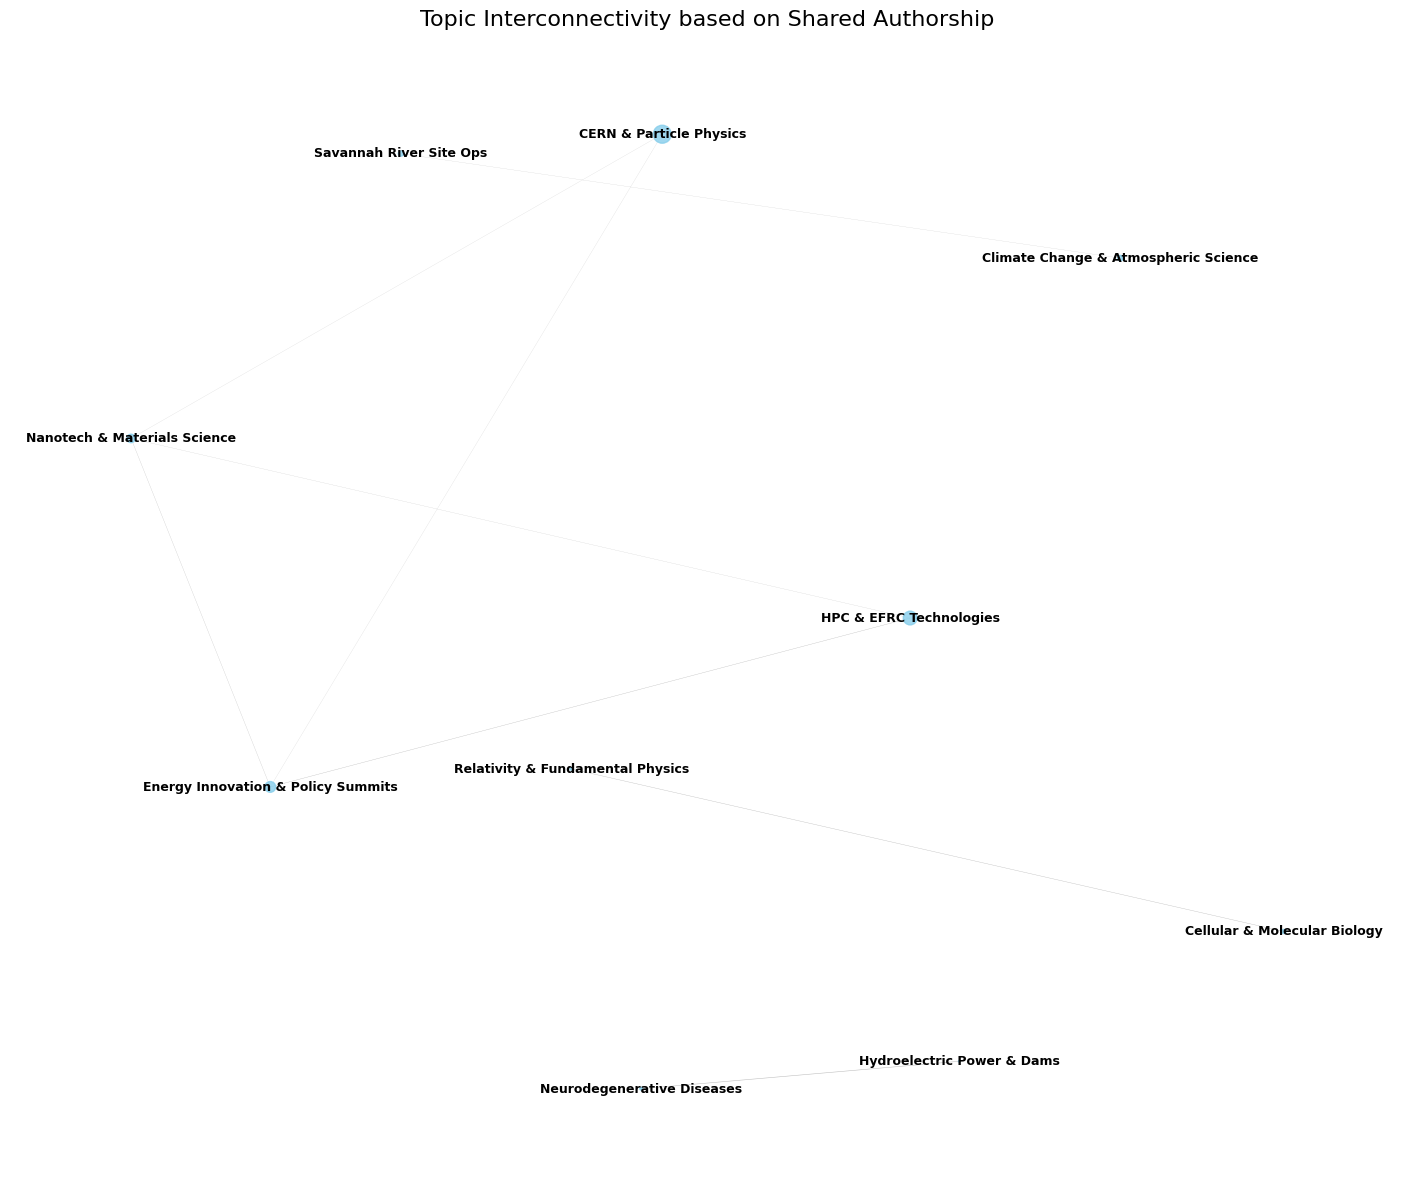


Topic network visualization generated.


In [58]:
# Build topic-topic network
threshold = 0.01
G_topics = nx.Graph()

full_topic_info_raw = topic_model.get_topic_info()

for topic_id in unique_topic_ids_for_network:
    topic_info_row = full_topic_info_raw[full_topic_info_raw['Topic'] == topic_id]

    if not topic_info_row.empty:
        topic_count = topic_info_row['Count'].iloc[0]

        if topic_count >= 5:
            G_topics.add_node(topic_id, size=topic_count)
        else:
            print(f"  Warning: Topic ID {topic_id} excluded from graph due to low document count ({topic_count}).")
    else:
        print(f"  ERROR: Topic ID {topic_id} from authors data not found in BERTopic's raw topic_info.")
        continue

for i_id in unique_topic_ids_for_network:
    for j_id in unique_topic_ids_for_network:
        if i_id >= j_id:
            continue

        if G_topics.has_node(i_id) and G_topics.has_node(j_id):
            similarity = normalized_adj_matrix.loc[i_id, j_id]
            if similarity > threshold:
                G_topics.add_edge(i_id, j_id, weight=similarity)

isolated_nodes = [node for node, degree in G_topics.degree() if degree == 0]
G_topics.remove_nodes_from(isolated_nodes)

plt.figure(figsize=(18, 15))
pos = nx.spring_layout(G_topics, k=0.5, iterations=50, seed=42)
node_sizes = [G_topics.nodes[node]['size'] * 0.2 for node in G_topics.nodes()]
nx.draw_networkx_nodes(G_topics, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
edge_widths = [G_topics.edges[edge]['weight'] * 10 for edge in G_topics.edges()]
nx.draw_networkx_edges(G_topics, pos, width=edge_widths, alpha=0.5, edge_color='gray')
labels = {node_id: new_topic_names.get(node_id, f"Unknown Topic {node_id}") for node_id in G_topics.nodes()}
nx.draw_networkx_labels(G_topics, pos, labels=labels, font_size=9, font_weight='bold')

plt.title("Topic Interconnectivity based on Shared Authorship".format(threshold), fontsize=16)
plt.axis('off')
plt.show()

print("\nTopic network visualization generated.")

# Author Topic Network

Author-Topic Network

In [59]:
# Data prep for author-topic mapping
MIN_VIDEOS_PER_AUTHOR_TOPIC = 1
MIN_AUTHOR_TOTAL_VIDEOS = 1
MIN_TOPIC_NETWORK_DEGREE = 1

In [60]:
# Create author-topic mapping
df_for_network = video_df_filtered[video_df_filtered['bertopic_topic_id'] != -1].copy()
df_for_network['authors'] = df_for_network['authors'].astype(str)
df_for_network['authors_processed_list'] = df_for_network['authors'].apply(parse_authors_simplified)

author_topic_data = []
for index, row in df_for_network.iterrows():
    topic_id = row['bertopic_topic_id']
    topic_name = row['bertopic_topic_name']
    video_id = row['osti_id']

    authors_in_row = row['authors_processed_list']

    if authors_in_row:
        for author in authors_in_row:
            author_topic_data.append({
                'author': author,
                'topic_id': topic_id,
                'topic_name': topic_name,
                'video_id': video_id
            })
author_topic_df = pd.DataFrame(author_topic_data)
author_topic_df = author_topic_df[~author_topic_df['author'].isin(['N/A', 'Unknown', '', None])]

print(f"Author-Topic mapping created. Total entries: {len(author_topic_df)}")

Author-Topic mapping created. Total entries: 3282


In [61]:
# Aggregate author-topic links
if not author_topic_df.empty:
    aggregated_author_topic_df = author_topic_df.groupby(['author', 'topic_name']).size().reset_index(name='strength')
    aggregated_author_topic_df = aggregated_author_topic_df[
        aggregated_author_topic_df['strength'] >= MIN_VIDEOS_PER_AUTHOR_TOPIC
    ].copy()

    print(f"Aggregated into {len(aggregated_author_topic_df)} author-topic links.")
else:
    print("author_topic_df is empty, cannot aggregate.")
    aggregated_author_topic_df = pd.DataFrame()

Aggregated into 2714 author-topic links.


In [62]:
# Prune author-topic network
def prune_author_topic_network_nodes(
    graph_to_prune,
    min_author_total_videos_thresh,
    min_topic_network_degree_thresh
):
    if graph_to_prune.number_of_nodes() == 0:
        print("Graph is empty, no pruning done.")
        return graph_to_prune

    G_pruned = graph_to_prune.copy()

    authors_to_remove = []
    for node, data in list(G_pruned.nodes(data=True)):
        if data.get('bipartite') == 0:
            total_strength = sum(G_pruned[node][neighbor]['weight'] for neighbor in G_pruned.neighbors(node) if 'weight' in G_pruned[node][neighbor])
            if total_strength < min_author_total_videos_thresh:
                authors_to_remove.append(node)
    G_pruned.remove_nodes_from(authors_to_remove)
    print(f"Pruning: Removed {len(authors_to_remove)} authors with total videos < {min_author_total_videos_thresh}")

    topics_to_remove = []
    for node, data in list(G_pruned.nodes(data=True)):
        if data.get('bipartite') == 1:
            if G_pruned.degree(node) < min_topic_network_degree_thresh:
                topics_to_remove.append(node)
    G_pruned.remove_nodes_from(topics_to_remove)
    print(f"Pruning: Removed {len(topics_to_remove)} topics with connections < {min_topic_network_degree_thresh}")

    isolated_nodes = list(nx.isolates(G_pruned))
    G_pruned.remove_nodes_from(isolated_nodes)
    print(f"Pruning: Removed {len(isolated_nodes)} isolated nodes after pruning.")

    return G_pruned

if not aggregated_author_topic_df.empty:
    B_raw = nx.Graph()
    authors_from_agg = aggregated_author_topic_df['author'].unique().tolist()

    all_known_topic_names_for_graph = [name for id, name in new_topic_names.items() if id != -1]

    B_raw.add_nodes_from(authors_from_agg, bipartite=0, label_type='author')
    B_raw.add_nodes_from(all_known_topic_names_for_graph, bipartite=1, label_type='topic')

    for index, row in aggregated_author_topic_df.iterrows():
        if row['author'] in B_raw and row['topic_name'] in B_raw:
            B_raw.add_edge(row['author'], row['topic_name'], weight=row['strength'])

    G_bipartite_pruned = prune_author_topic_network_nodes(
        B_raw,
        MIN_AUTHOR_TOTAL_VIDEOS,
        MIN_TOPIC_NETWORK_DEGREE
    )
    print("\nAuthor-Topic Network pruning complete.")
    print(f"Nodes in pruned graph: {G_bipartite_pruned.number_of_nodes()}")
    print(f"Edges in pruned graph: {G_bipartite_pruned.number_of_edges()}")
else:
    print("Aggregated author-topic DataFrame is empty.")
    G_bipartite_pruned = nx.Graph()

Pruning: Removed 0 authors with total videos < 1
Pruning: Removed 0 topics with connections < 1
Pruning: Removed 0 isolated nodes after pruning.

Author-Topic Network pruning complete.
Nodes in pruned graph: 2612
Edges in pruned graph: 2714



Author-Topic Network visualization.


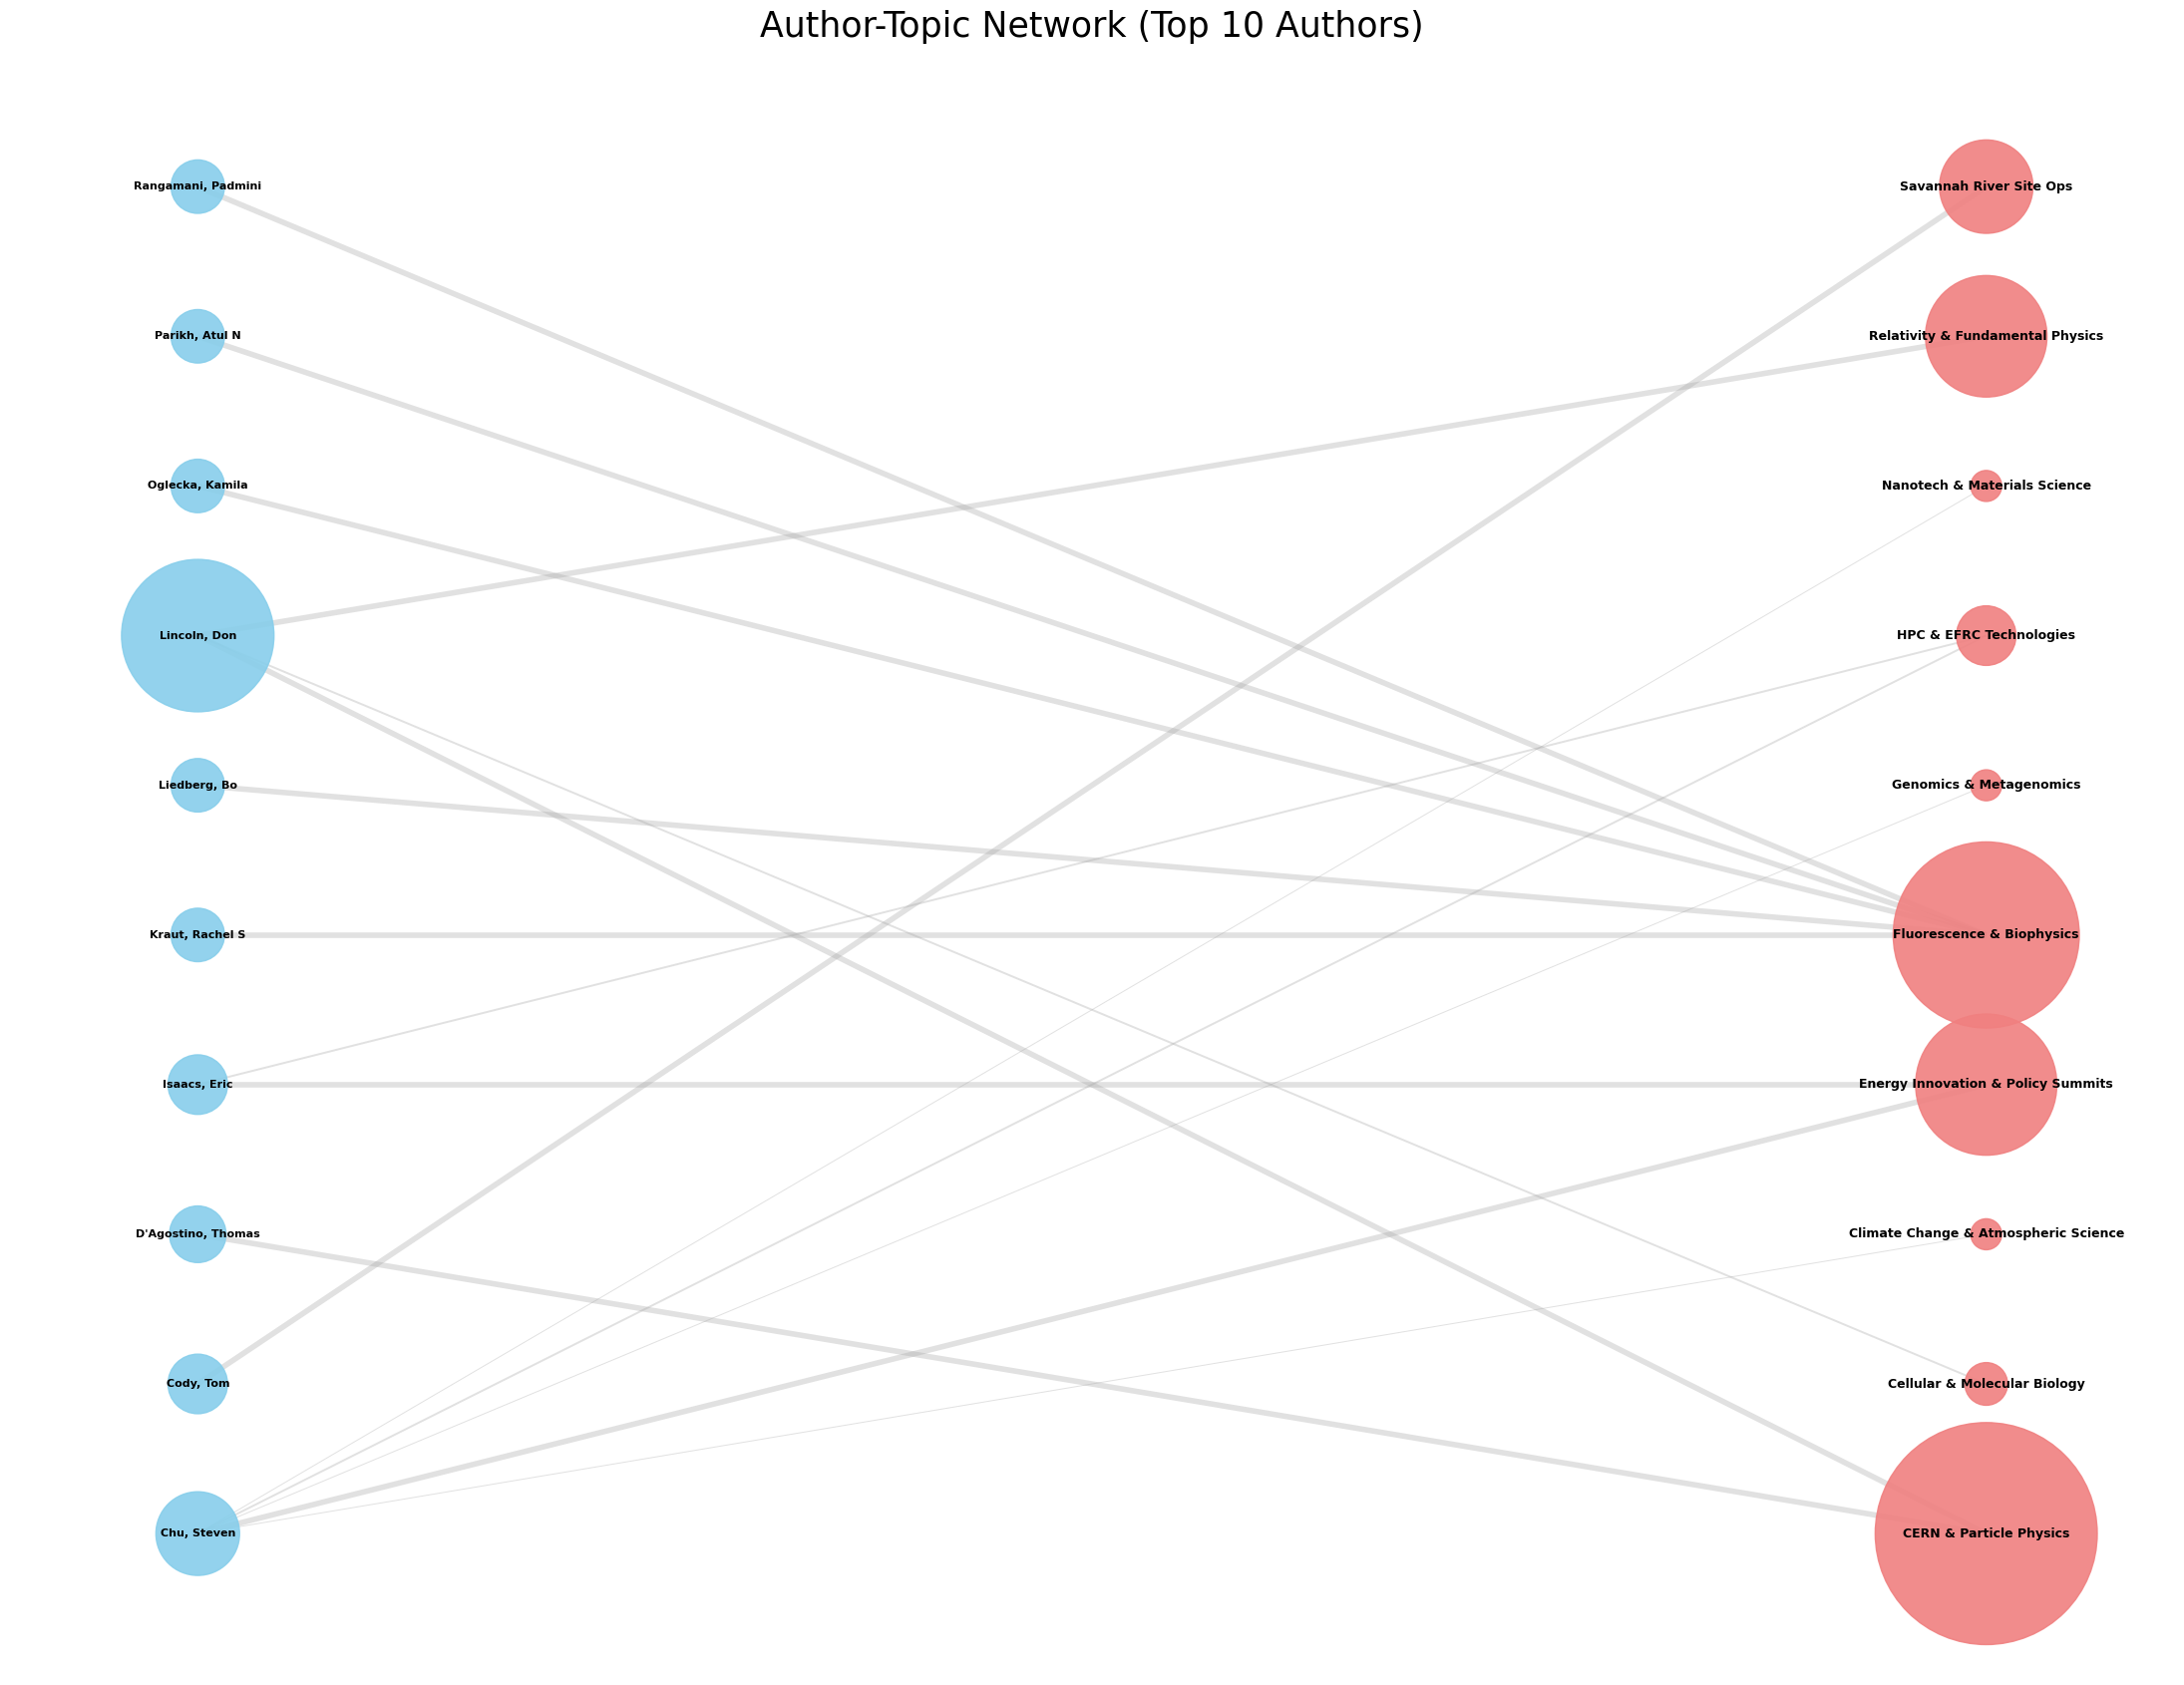

In [63]:
# Visualize author-topic network
def visualize_author_topic_network(G_author_topic, min_author_total_videos, min_topic_network_degree):
    if not G_author_topic.nodes():
        return

    authors_nodes = {n for n in G_author_topic.nodes() if G_author_topic.nodes[n].get('bipartite') == 0}
    topics_nodes = {n for n in G_author_topic.nodes() if G_author_topic.nodes[n].get('bipartite') == 1}

    if not authors_nodes or not topics_nodes:
        print(f"Graph too sparse after pruning (Authors: {len(authors_nodes)}, Topics: {len(topics_nodes)}).")
        return

    num_top_authors_to_display = 10
    author_total_strengths = {node: G_author_topic.degree(node, weight='weight') for node in authors_nodes}
    top_authors_sorted_list = sorted(author_total_strengths.items(), key=lambda item: item[1], reverse=True)[:num_top_authors_to_display]
    authors_to_display_set = {author for author, strength in top_authors_sorted_list}

    G_viz = G_author_topic.subgraph(list(authors_to_display_set) + list(topics_nodes)).copy()
    isolated_nodes_viz = list(nx.isolates(G_viz))
    G_viz.remove_nodes_from(isolated_nodes_viz)

    authors_nodes = {n for n in G_viz.nodes() if G_viz.nodes[n].get('bipartite') == 0}
    topics_nodes = {n for n in G_viz.nodes() if G_viz.nodes[n].get('bipartite') == 1}

    if not authors_nodes or not topics_nodes:
        print(f"Graph too sparse after filtering to Top {num_top_authors_to_display} authors.")
        return

    plt.figure(figsize=(22,17))

    left_nodes_sorted = sorted(list(authors_nodes))
    right_nodes_sorted = sorted(list(topics_nodes))

    pos = {}
    author_y_spacing = 1.0 / (len(left_nodes_sorted) - 1) if len(left_nodes_sorted) > 1 else 1.0
    for i, node in enumerate(left_nodes_sorted):
        pos[node] = (0, i * author_y_spacing)

    if len(right_nodes_sorted) > 0 and len(left_nodes_sorted) > 0:
        topic_y_spacing_factor = (len(left_nodes_sorted) - 1) / (len(right_nodes_sorted) - 1) if len(right_nodes_sorted) > 1 else 1.0
        for i, node in enumerate(right_nodes_sorted):
            pos[node] = (1, i * author_y_spacing * topic_y_spacing_factor)
    elif len(right_nodes_sorted) > 0:
        for i, node in enumerate(right_nodes_sorted):
            pos[node] = (1, i * author_y_spacing)

    base_node_size = 50
    author_size_multiplier = 180
    topic_size_multiplier = 450

    author_node_sizes = [base_node_size + G_viz.degree(node, weight='weight') * author_size_multiplier for node in authors_nodes]
    topic_node_sizes = [base_node_size + G_viz.degree(node, weight='weight') * topic_size_multiplier for node in topics_nodes]

    nx.draw_networkx_nodes(G_viz, pos, nodelist=list(authors_nodes), node_color='skyblue', node_size=author_node_sizes, alpha=0.9, label='Authors')
    nx.draw_networkx_nodes(G_viz, pos, nodelist=list(topics_nodes), node_color='lightcoral', node_size=topic_node_sizes, alpha=0.9, label='Topics')

    edge_weights = [d['weight'] for (u, v, d) in G_viz.edges(data=True)]
    edge_widths_scaled = [min(w * 0.7, 4.0) for w in edge_weights]

    nx.draw_networkx_edges(G_viz, pos, width=edge_widths_scaled, alpha=0.35, edge_color='darkgray')

    author_labels = {node: node for node in authors_nodes}
    topic_labels = {node: node for node in topics_nodes}
    nx.draw_networkx_labels(G_viz, pos, labels=author_labels, font_size=8, font_weight='bold', font_color='black')
    nx.draw_networkx_labels(G_viz, pos, labels=topic_labels, font_size=9, font_weight='bold', font_color='black')


    plt.title(f"Author-Topic Network (Top {num_top_authors_to_display} Authors)", fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nAuthor-Topic Network visualization.")
visualize_author_topic_network(G_bipartite_pruned, MIN_AUTHOR_TOTAL_VIDEOS, MIN_TOPIC_NETWORK_DEGREE)

Author Topic Heatmap

In [64]:
# Define heatmap parameters
min_author_videos_for_heatmap = 2
num_top_authors_for_heatmap_display = 20

topics_for_heatmap = [name for id, name in new_topic_names.items() if id != -1]
topics_for_heatmap.sort()

In [65]:
# Sort and filter aggregated_author_topic_df
author_total_strengths_for_heatmap = aggregated_author_topic_df.groupby('author')['strength'].sum()
top_authors_for_display = author_total_strengths_for_heatmap.nlargest(num_top_authors_for_heatmap_display).index.tolist()

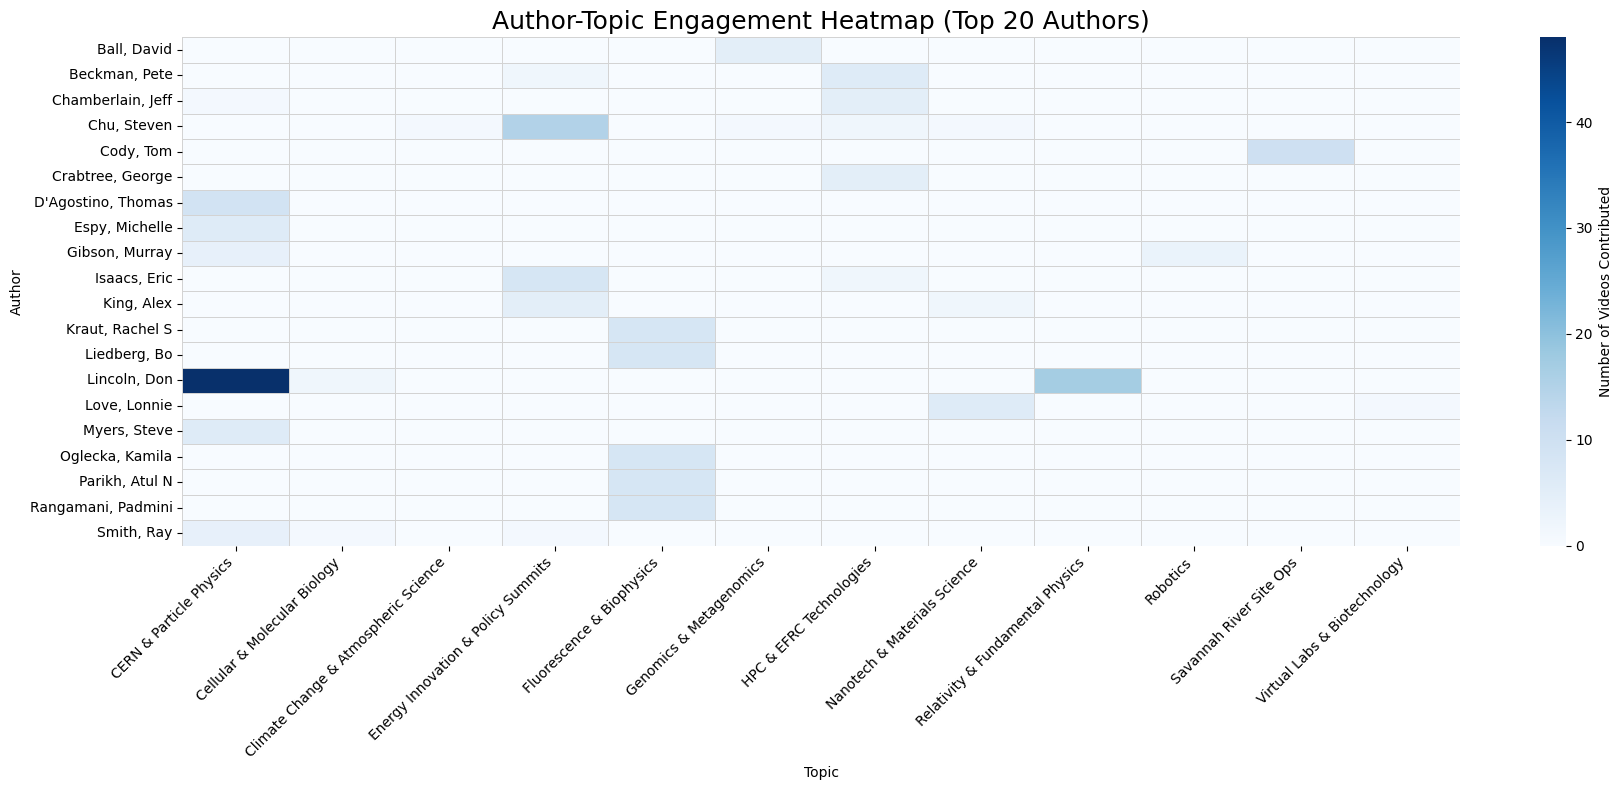


Heatmap of Author-Topic Engagement generated.


In [66]:
# Generate heatmap
heatmap_df_source = aggregated_author_topic_df[
    aggregated_author_topic_df['author'].isin(top_authors_for_display) &
    aggregated_author_topic_df['topic_name'].isin(topics_for_heatmap)
].copy()

if heatmap_df_source.empty:
    print("No data to generate heatmap after filtering.")
else:
    author_topic_pivot = heatmap_df_source.pivot_table(
        index='author',
        columns='topic_name',
        values='strength',
        fill_value=0
    )

    topics_for_heatmap_final = [t for t in topics_for_heatmap if t in author_topic_pivot.columns]
    author_topic_pivot = author_topic_pivot[topics_for_heatmap_final]

    plt.figure(figsize=(min(25, len(topics_for_heatmap_final) * 1.5), min(30, len(top_authors_for_display) * 0.4))) # Dynamic sizing

    sns.heatmap(
        author_topic_pivot,
        cmap="Blues",
        annot=False,
        fmt="g",
        linewidths=.5,
        linecolor='lightgray',
        cbar_kws={'label': 'Number of Videos Contributed'},
        square=False
    )

    plt.title(f"Author-Topic Engagement Heatmap (Top {num_top_authors_for_heatmap_display} Authors)", fontsize=18)
    plt.xlabel("Topic")
    plt.ylabel("Author")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("\nHeatmap of Author-Topic Engagement generated.")

Topic Only Network

In [67]:
# Semantic Topic-Topic Network visualization
all_model_topic_ids = [id for id in topic_model.get_topics() if id != -1]
topic_embeddings_df = topic_model.get_topic_info()
topic_embeddings_df = topic_embeddings_df[topic_embeddings_df['Topic'] != -1].sort_values(by='Topic')
ordered_topic_embeddings = [topic_model.topic_embeddings_[id] for id in topic_embeddings_df['Topic'].tolist()]
ordered_topic_embeddings_np = np.array(ordered_topic_embeddings)
semantic_similarity_matrix = cosine_similarity(ordered_topic_embeddings_np)
semantic_similarity_df = pd.DataFrame(
    semantic_similarity_matrix,
    index=topic_embeddings_df['Topic'].tolist(),
    columns=topic_embeddings_df['Topic'].tolist()
)
print("\nSemantic similarity matrix indexed by Topic ID):")
print(semantic_similarity_df.head())


Semantic similarity matrix indexed by Topic ID):
         0         1         2         3         4         5         6   \
0  1.000000  0.818994  0.810878  0.717906  0.881239  0.757198  0.289752   
1  0.818994  1.000000  0.558917  0.441608  0.756093  0.648809  0.282657   
2  0.810878  0.558917  1.000000  0.549300  0.716223  0.599260  0.186810   
3  0.717906  0.441608  0.549300  1.000000  0.531931  0.429782  0.141467   
4  0.881239  0.756093  0.716223  0.531931  1.000000  0.633837  0.390218   

         7         8         9         10        11        12        13  \
0  0.597079  0.554868  0.528356  0.585177  0.521548  0.546785  0.343237   
1  0.414630  0.368397  0.462037  0.462674  0.372928  0.369447  0.241886   
2  0.498564  0.470116  0.261186  0.419041  0.435115  0.342264  0.209622   
3  0.482361  0.379268  0.487057  0.269732  0.264528  0.555641  0.242943   
4  0.523818  0.454923  0.417383  0.542449  0.437722  0.442363  0.300642   

         14        15        16        17       

In [68]:
# Build the NetworkX Graph based on semantic similarity
semantic_threshold = 0.30
G_semantic = nx.Graph()

full_topic_info_raw = topic_model.get_topic_info()

for topic_id in all_model_topic_ids:
    topic_info_row = full_topic_info_raw[full_topic_info_raw['Topic'] == topic_id]
    if not topic_info_row.empty:
        topic_count = topic_info_row['Count'].iloc[0]
        if topic_count >= 5:
            G_semantic.add_node(topic_id, size=topic_count)
        else:
            print(f"  Warning: Semantic topic ID {topic_id} excluded from graph due to low document count ({topic_count}).")
    else:
        print(f"  ERROR: Semantic topic ID {topic_id} not found in BERTopic's raw topic_info.")
        continue

for i_idx, i_id in enumerate(all_model_topic_ids):
    for j_idx, j_id in enumerate(all_model_topic_ids):
        if i_idx >= j_idx:
            continue
        if G_semantic.has_node(i_id) and G_semantic.has_node(j_id):
            similarity = semantic_similarity_matrix[i_idx, j_idx]
            if similarity > semantic_threshold:
                G_semantic.add_edge(i_id, j_id, weight=similarity)

isolated_nodes_semantic = [node for node, degree in G_semantic.degree() if degree == 0]
G_semantic.remove_nodes_from(isolated_nodes_semantic)

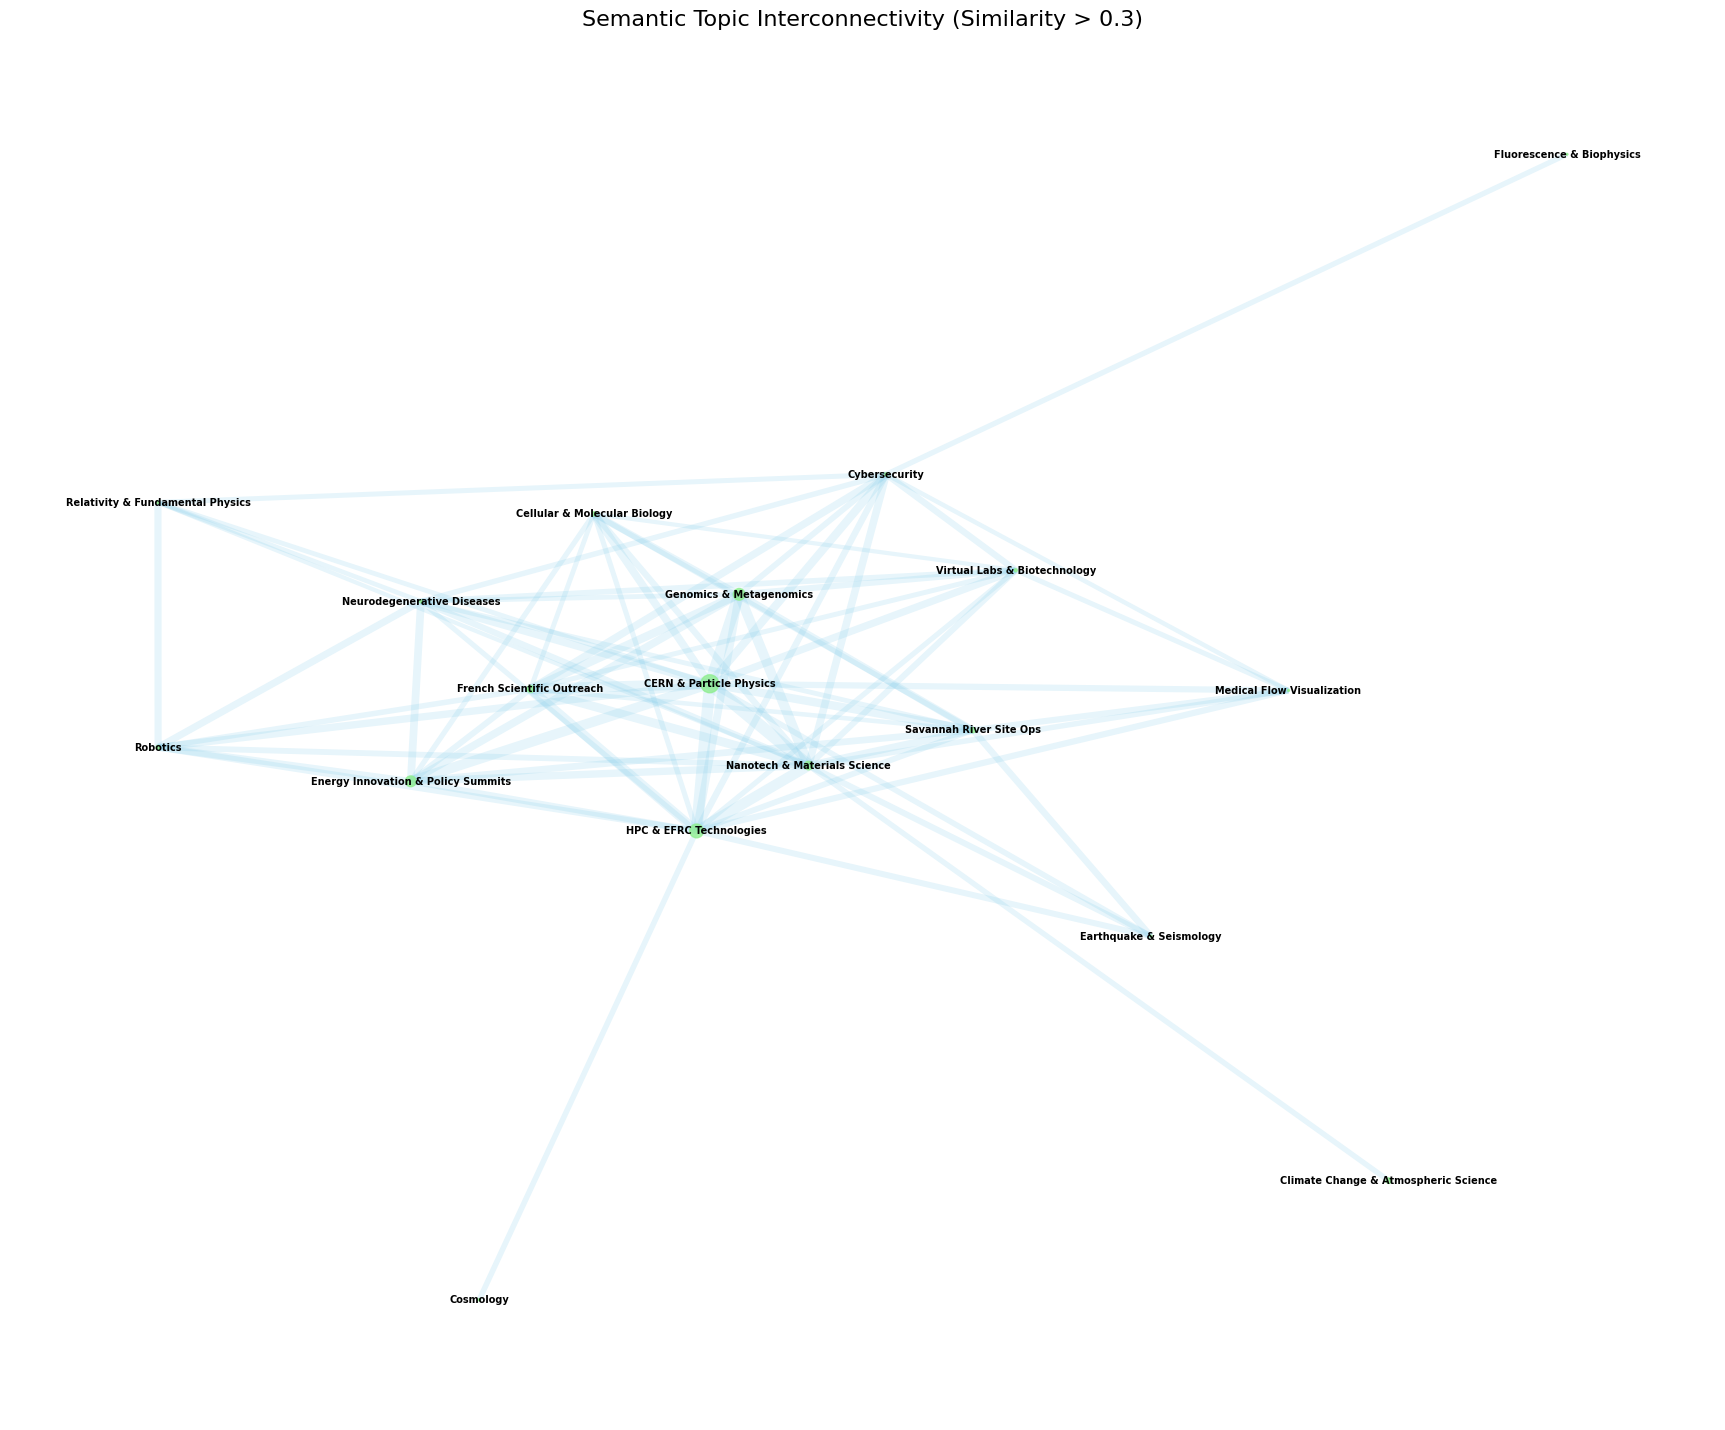


Semantic topic network visualization generated.


In [69]:
# Plotting the network
plt.figure(figsize=(22, 18))
pos_semantic = nx.spring_layout(G_semantic, k=0.9, iterations=100, seed=42)

node_sizes_semantic = [G_semantic.nodes[node]['size'] * 0.2 for node in G_semantic.nodes()]
nx.draw_networkx_nodes(G_semantic, pos_semantic, node_size=node_sizes_semantic, node_color='lightgreen', alpha=0.8)

edge_widths_semantic = [G_semantic.edges[edge]['weight'] * 10 for edge in G_semantic.edges()]
nx.draw_networkx_edges(
    G_semantic,
    pos_semantic,
    width=edge_widths_semantic,
    alpha=0.2,
    edge_color='skyblue'
)

labels_semantic = {node_id: new_topic_names.get(node_id, f"Unknown Topic {node_id}") for node_id in G_semantic.nodes()}
nx.draw_networkx_labels(G_semantic, pos_semantic, labels=labels_semantic, font_size=7, font_weight='bold') # <--- ADJUSTED FONT SIZE

plt.title("Semantic Topic Interconnectivity (Similarity > {})".format(semantic_threshold), fontsize=16)
plt.axis('off')
plt.show()

print("\nSemantic topic network visualization generated.")

# Objective 2


# Semantic Search

# Naive Bayes Classification

In [70]:
# Create a DataFrame for Topic Classification
classification_df_text = video_df_filtered.copy()
classification_df_text['bertopic_topic_id'] = topics
classification_df_text['bertopic_topic_name'] = classification_df_text['bertopic_topic_id'].map(new_topic_names)
classification_df_text['combined_text'] = classification_df_text['title'].fillna('') + " " + classification_df_text['description'].fillna('')
classification_df_text = classification_df_text[classification_df_text['combined_text'].str.strip() != '']

def clean_text_for_classifier(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

classification_df_text['cleaned_combined_text'] = classification_df_text['combined_text'].apply(clean_text_for_classifier)
classification_df_text = classification_df_text[classification_df_text['bertopic_topic_id'] != -1].copy()


In [71]:
# Data prep for Naive Bayes
X_text = classification_df_text['cleaned_combined_text']
y_text = classification_df_text['bertopic_topic_name']

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y_text, test_size=0.2, random_state=42, stratify=y_text)

vectorizer_text = TfidfVectorizer(max_features=10000)
X_train_vectorized_text = vectorizer_text.fit_transform(X_train_text)
X_test_vectorized_text = vectorizer_text.transform(X_test_text)

print(f"Training set size: {len(X_train_text)}")
print(f"Testing set size: {len(X_test_text)}")
print(f"Vectorizer vocabulary size: {len(vectorizer_text.vocabulary_)}")

Training set size: 2116
Testing set size: 530
Vectorizer vocabulary size: 10000


In [72]:
# Train and evaluate
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized_text, y_train_text)
print("Naive Bayes classifier training complete.")

y_pred_text = nb_classifier.predict(X_test_vectorized_text)

print("\nNaive Bayes Classifier Evaluation (Combined Text Data)")
print(f"Accuracy: {accuracy_score(y_test_text, y_pred_text):.4f}")
print("\nClassification Report (Combined Text Data):")
print(classification_report(y_test_text, y_pred_text, zero_division=0))

Naive Bayes classifier training complete.

Naive Bayes Classifier Evaluation (Combined Text Data)
Accuracy: 0.5906

Classification Report (Combined Text Data):
                                      precision    recall  f1-score   support

             CERN & Particle Physics       0.46      0.99      0.63       167
        Cellular & Molecular Biology       0.00      0.00      0.00         9
Climate Change & Atmospheric Science       0.00      0.00      0.00        15
                           Cosmology       0.00      0.00      0.00         3
                       Cybersecurity       0.00      0.00      0.00         5
             Earthquake & Seismology       0.00      0.00      0.00         2
  Energy Innovation & Policy Summits       1.00      0.17      0.29        60
           Fluorescence & Biophysics       0.00      0.00      0.00         2
          French Scientific Outreach       0.90      0.76      0.83        25
             Genomics & Metagenomics       0.98      0.69  

# Semantic Search Embeddings

# Logistic Regression Classification

Logistic Regression

In [73]:
# Pre-processing for classifier
def clean_text_for_classifier(text):
    if not isinstance(text, str):
        return ""
    tokens = preprocess_text(text)
    return ' '.join(tokens)

In [74]:
# Logistic regression classifier
classification_df_text = video_df_filtered.copy()
classification_df_text['bertopic_topic_id'] = topics
classification_df_text['bertopic_topic_name'] = classification_df_text['bertopic_topic_id'].map(new_topic_names)
classification_df_text['raw_combined_text'] = classification_df_text['title'].fillna('') + " " + classification_df_text['description'].fillna('')
classification_df_text = classification_df_text[classification_df_text['raw_combined_text'].str.strip() != '']
classification_df_text['cleaned_combined_text_processed'] = classification_df_text['raw_combined_text'].apply(preprocess_text)
classification_df_text = classification_df_text[
    classification_df_text['cleaned_combined_text_processed'].apply(lambda x: len(x) > 0)
].copy()
classification_df_text = classification_df_text[classification_df_text['bertopic_topic_id'] != -1].copy()

X_text = classification_df_text['cleaned_combined_text_processed'].apply(lambda tokens: ' '.join(tokens))
y_text = classification_df_text['bertopic_topic_name']

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y_text, test_size=0.2, random_state=42, stratify=y_text)

vectorizer_text = TfidfVectorizer(max_features=10000)
X_train_vectorized_text = vectorizer_text.fit_transform(X_train_text)
X_test_vectorized_text = vectorizer_text.transform(X_test_text)

print(f"\nTraining set size: {len(X_train_text)}")
print(f"Testing set size: {len(X_test_text)}")
print(f"Vectorizer vocabulary size: {len(vectorizer_text.vocabulary_)}")


Training set size: 2116
Testing set size: 530
Vectorizer vocabulary size: 10000


In [75]:
# Train and evaluate logistic regression
classifier = LogisticRegression(random_state=42, max_iter=1000)
classifier.fit(X_train_vectorized_text, y_train_text)
print("Logistic Regression classifier training complete.")

y_pred_text = classifier.predict(X_test_vectorized_text)

print("\nLogistic Regression Classifier Evaluation (Combined Text Data)")
print(f"Accuracy: {accuracy_score(y_test_text, y_pred_text):.4f}")
print("\nClassification Report (Combined Text Data):")
print(classification_report(y_test_text, y_pred_text, zero_division=0))

Logistic Regression classifier training complete.

Logistic Regression Classifier Evaluation (Combined Text Data)
Accuracy: 0.7642

Classification Report (Combined Text Data):
                                      precision    recall  f1-score   support

             CERN & Particle Physics       0.64      0.98      0.77       167
        Cellular & Molecular Biology       1.00      0.11      0.20         9
Climate Change & Atmospheric Science       1.00      0.27      0.42        15
                           Cosmology       1.00      1.00      1.00         3
                       Cybersecurity       0.00      0.00      0.00         5
             Earthquake & Seismology       0.00      0.00      0.00         2
  Energy Innovation & Policy Summits       0.80      0.65      0.72        60
           Fluorescence & Biophysics       0.00      0.00      0.00         2
          French Scientific Outreach       0.93      0.52      0.67        25
             Genomics & Metagenomics       

In [76]:
# Implement semantic search function
from sklearn.metrics.pairwise import cosine_similarity

def semantic_search(query, document_embeddings_array, docs_df_full, top_k=5):
    query_embedding = embedding_model.encode([query])
    similarities = cosine_similarity(query_embedding, document_embeddings_array).flatten()

    top_indices = similarities.argsort()[-top_k:][::-1]

    results = []
    for i in top_indices:
        results.append({
            'title': docs_df_full.iloc[i]['title'],
            'description_snippet': str(docs_df_full.iloc[i]['description'])[:200] + '...',
            'similarity_score': similarities[i],
            'bertopic_topic': docs_df_full.iloc[i]['bertopic_topic_name']
        })
    return results

print("\nSemantic search function defined.")


Semantic search function defined.


In [77]:
# Enhance semantic search function
def semantic_search_filtered_by_topic(query, document_embeddings_array, docs_df_full, vectorizer, classifier, top_k=5):
    predicted_query_topic_cleaned_text = clean_text_for_classifier(query)
    if not predicted_query_topic_cleaned_text:
        print("Query is too short or generic for topic prediction after cleaning. Cannot filter.")
        return []

    query_vectorized = vectorizer.transform([predicted_query_topic_cleaned_text])
    predicted_topic_name = classifier.predict(query_vectorized)[0]

    print(f"\nQuery '{query}' predicted topic: {predicted_topic_name}")

    search_df = docs_df_full.copy()
    search_df['similarity_score'] = cosine_similarity(embedding_model.encode([query]), document_embeddings_array).flatten()

    filtered_df = search_df[search_df['bertopic_topic_name'] == predicted_topic_name]

    filtered_df = filtered_df.sort_values(by='similarity_score', ascending=False)

    results = []
    for index, row in filtered_df.head(top_k).iterrows():
        results.append({
            'title': row['title'],
            'description_snippet': str(row['description'])[:200] + '...',
            'similarity_score': row['similarity_score'],
            'bertopic_topic': row['bertopic_topic_name']
        })
    return results

def semantic_search_boosted_by_topic(query, document_embeddings_array, docs_df_full, vectorizer, classifier, top_k=5, boost_factor=1.2):
    predicted_query_topic_cleaned_text = clean_text_for_classifier(query)
    if not predicted_query_topic_cleaned_text:
        print("Query is too short or generic for topic prediction after cleaning. Cannot boost.")
        return []

    query_vectorizer = vectorizer.transform([predicted_query_topic_cleaned_text])
    predicted_topic_name = classifier.predict(query_vectorizer)[0]

    print(f"\nQuery '{query}' predicted topic: {predicted_topic_name}")

    query_embedding = embedding_model.encode([query])
    similarities = cosine_similarity(query_embedding, document_embeddings_array).flatten()

    boosted_similarities = np.copy(similarities)
    for i, doc_topic in enumerate(docs_df_full['bertopic_topic_name']):
        if doc_topic == predicted_topic_name:
            boosted_similarities[i] *= boost_factor

    top_indices = boosted_similarities.argsort()[-top_k:][::-1]

    results = []
    for i in top_indices:
        results.append({
            'title': docs_df_full.iloc[i]['title'],
            'description_snippet': str(docs_df_full.iloc[i]['description'])[:200] + '...',
            'similarity_score_original': similarities[i],
            'similarity_score_boosted': boosted_similarities[i],
            'bertopic_topic': docs_df_full.iloc[i]['bertopic_topic_name']
        })
    return results

print("Enhanced semantic search functions defined.")

Enhanced semantic search functions defined.


# Semantic Search Queries

In [78]:
# Practice usage of specific queries
query_1 = "metagenomics sequencing for environmental studies"
print(f"\n-Running Search for Query 1: '{query_1}'")

print("\nBasic Semantic Search Results (for comparison)")
results_basic_1 = semantic_search(query_1, document_embeddings, video_df_filtered, top_k=5)
for i, result in enumerate(results_basic_1):
    print(f"Rank {i+1} (Score: {result['similarity_score']:.4f})")
    print(f"  Title: {result['title']}")
    print(f"  Topic: {result['bertopic_topic']}")
    print(f"  Description: {result['description_snippet']}")
    print("-" * 30)


print("\nSemantic Search (Filtered by Query Topic) Results")
results_filtered_1 = semantic_search_filtered_by_topic(query_1, document_embeddings, video_df_filtered, vectorizer_text, classifier, top_k=5)
if results_filtered_1:
    for i, result in enumerate(results_filtered_1):
        print(f"Rank {i+1} (Score: {result['similarity_score']:.4f})")
        print(f"  Title: {result['title']}")
        print(f"  Topic: {result['bertopic_topic']}")
        print(f"  Description: {result['description_snippet']}")
        print("-" * 30)
else:
    print("No results found after filtering by predicted topic.")


print("\n-Semantic Search (Boosted by Query Topic) Results")
results_boosted_1 = semantic_search_boosted_by_topic(query_1, document_embeddings, video_df_filtered, vectorizer_text, classifier, top_k=5, boost_factor=1.2)
for i, result in enumerate(results_boosted_1):
    print(f"Rank {i+1} (Original Score: {result['similarity_score_original']:.4f}, Boosted Score: {result['similarity_score_boosted']:.4f})")
    print(f"  Title: {result['title']}")
    print(f"  Topic: {result['bertopic_topic']}")
    print(f"  Description: {result['description_snippet']}")
    print("-" * 30)


-Running Search for Query 1: 'metagenomics sequencing for environmental studies'

Basic Semantic Search Results (for comparison)
Rank 1 (Score: 0.7357)
  Title: Analysis of Metagenomic Sequences: From Megabases to Terabases
  Topic: Genomics & Metagenomics
  Description: Nikos Krypides of the DOE Joint Genome Institute discusses metagenomics and the challenge of dealing with terabases of data on June 4, 2010 at the "Sequencing, Finishing, Analysis in the Future" meeti...
------------------------------
Rank 2 (Score: 0.7335)
  Title: Meta-IDBA: A de novo Assembler for Metagenomic Data (Metagenomics Informatics Challenges Workshop: 10K Genomes at a Time)
  Topic: Genomics & Metagenomics
  Description: University of Hong Kong's Francis Chin on "Meta-­IDBA: A de novo Assembler for Metagenomic Data" at the Metagenomics Informatics Challenges Workshop held at the DOE JGI on October 12-13, 2011....
------------------------------
Rank 3 (Score: 0.7275)
  Title: Metagenomics for Etiologic Agen

In [79]:
# Semantic search of ambiguous query
query_2 = "research on materials science"
print(f"\nRunning Search for Query 2: '{query_2}' ---")

print("\nasic Semantic Search Results (for comparison)")
results_basic_2 = semantic_search(query_2, document_embeddings, video_df_filtered, top_k=5)
for i, result in enumerate(results_basic_2):
    print(f"Rank {i+1} (Score: {result['similarity_score']:.4f})")
    print(f"  Title: {result['title']}")
    print(f"  Topic: {result['bertopic_topic']}")
    print(f"  Description: {result['description_snippet']}")
    print("-" * 30)

print("\nSemantic Search (Filtered by Query Topic) Results")
results_filtered_2 = semantic_search_filtered_by_topic(query_2, document_embeddings, video_df_filtered, vectorizer_text, classifier, top_k=5)
if results_filtered_2:
    for i, result in enumerate(results_filtered_2):
        print(f"Rank {i+1} (Score: {result['similarity_score']:.4f})")
        print(f"  Title: {result['title']}")
        print(f"  Topic: {result['bertopic_topic']}")
        print(f"  Description: {result['description_snippet']}")
        print("-" * 30)
else:
    print("No results found after filtering by predicted topic.")

print("\n--- Semantic Search (Boosted by Query Topic) Results ---")
results_boosted_2 = semantic_search_boosted_by_topic(query_2, document_embeddings, video_df_filtered, vectorizer_text, classifier, top_k=5, boost_factor=1.2)
for i, result in enumerate(results_boosted_2):
    print(f"Rank {i+1} (Original Score: {result['similarity_score_original']:.4f}, Boosted Score: {result['similarity_score_boosted']:.4f})")
    print(f"  Title: {result['title']}")
    print(f"  Topic: {result['bertopic_topic']}")
    print(f"  Description: {result['description_snippet']}")
    print("-" * 30)


Running Search for Query 2: 'research on materials science' ---

asic Semantic Search Results (for comparison)
Rank 1 (Score: 0.6302)
  Title: Argonne's Materials Engineering Research Facility
  Topic: Outlier / General Content
  Description: Take a look inside Argonne National Laboratory's Materials Engineering Research Facility....
------------------------------
Rank 2 (Score: 0.5637)
  Title: S&TR Preview: Understanding Materials at the Nanoscale
  Topic: Outlier / General Content
  Description: Six projects funded by the Department of Energy's Office of Basic Energy Sciences showcase Livermore's expertise in materials science research....
------------------------------
Rank 3 (Score: 0.5618)
  Title: Nanovision:  Nanotubes, Nanowires, and Nanoparticles (404th Brookhaven Lecture)
  Topic: Nanotech & Materials Science
  Description: A very few years ago, the field of nanoscience — the science of materials at the nanometer (nm), or billionth-of-a-meter scale — was relatively unexplor

In [80]:
# Display prediction results
results_filtered_1 = semantic_search_filtered_by_topic(query_1, document_embeddings, video_df_filtered, vectorizer_text, classifier, top_k=5)
results_filtered_2 = semantic_search_filtered_by_topic(query_2, document_embeddings, video_df_filtered, vectorizer_text, classifier, top_k=5)


Query 'metagenomics sequencing for environmental studies' predicted topic: Genomics & Metagenomics

Query 'research on materials science' predicted topic: Nanotech & Materials Science


In [81]:
# Keyword search for comparison
def basic_keyword_search(query, docs_df_full, top_k=5):
    query_lower = query.lower()
    results_df = docs_df_full[
        docs_df_full['title'].astype(str).str.lower().str.contains(query_lower, na=False) |
        docs_df_full['description'].astype(str).str.lower().str.contains(query_lower, na=False)
    ].head(top_k)

    results = []
    for index, row in results_df.iterrows():
        results.append({
            'title': row['title'],
            'description_snippet': str(row['description'])[:200] + '...',
            'bertopic_topic': row['bertopic_topic_name']
        })
    return results

print("\nRunning Basic Keyword Search Example")
keyword_query = "solar panel"
keyword_results = basic_keyword_search(keyword_query, video_df_filtered, top_k=5)

for i, result in enumerate(keyword_results):
    print(f"Rank {i+1}")
    print(f"  Title: {result['title']}")
    print(f"  Topic: {result['bertopic_topic']}")
    print(f"  Description: {result['description_snippet']}")
    print("-" * 30)


Running Basic Keyword Search Example
Rank 1
  Title: A Day at the Races: NREL Hosts Colorado Middle School Students With STEM Skills
  Topic: Energy Innovation & Policy Summits
  Description: Technology and imagination came together at the National Renewable Energy Laboratory on May 20 when 53 teams from 18 Colorado middle schools turned a parking lot into a raceway. The students used the ...
------------------------------
Rank 2
  Title: ORNL Demonstrates Large-Scale Technique to Produce Quantum Dots
  Topic: HPC & EFRC Technologies
  Description: A method to produce significant amounts of semiconducting nanoparticles for light-emitting displays, sensors, solar panels and biomedical applications has gained momentum with a demonstration by resea...
------------------------------
Rank 3
  Title: #CleanTechNow
  Topic: Outlier / General Content
  Description: Over the past four years, America's clean energy future has come into sharper focus. Yesterday's visionary goals are now hard dat

# BERTopic Visualizations

BERTopic Visualizations

In [82]:
# Inter-topic Distance Map
inter_topic_map_fig = topic_model.visualize_topics(
    title="Inter-topic Distance Map",
    width=900,
    height=600
)
display(inter_topic_map_fig)
print("Inter-topic Distance Map generated.")

Inter-topic Distance Map generated.



Generating Vertical Bar Charts for top 5 topics (showing top 5 words each), excluding Topic 0...


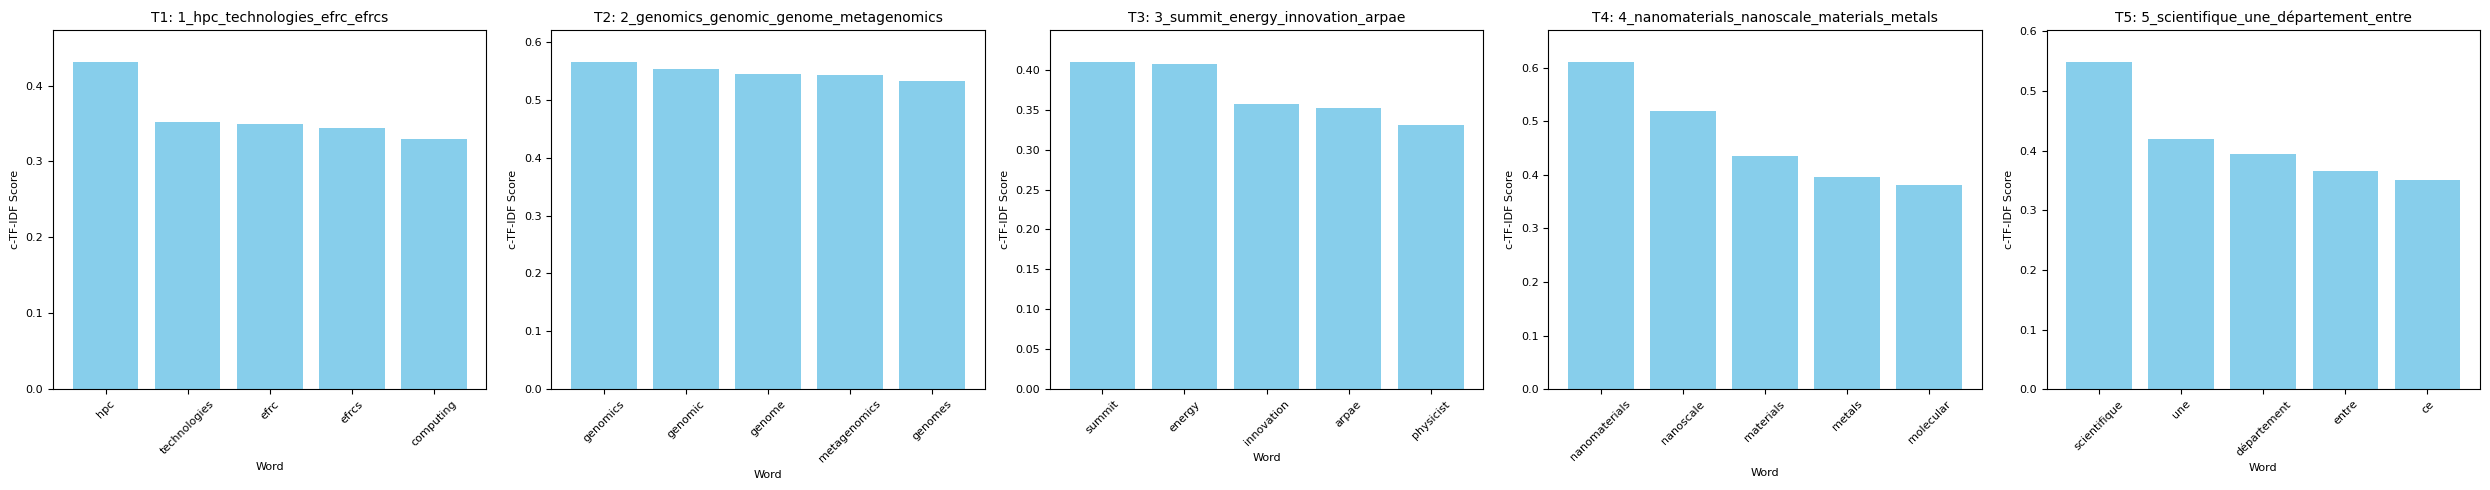


Topic Word Score Bar Charts generated.


In [83]:
# Top word bar chart
num_topics_to_display_barcharts = 5
n_words_to_display_per_topic = 5

sorted_topics_by_count = topic_model.get_topic_info().sort_values('Count', ascending=False)['Topic'].tolist()
if -1 in sorted_topics_by_count:
    sorted_topics_by_count.remove(-1)
if 0 in sorted_topics_by_count:
    sorted_topics_by_count.remove(0)

print(f"\nGenerating Vertical Bar Charts for top {num_topics_to_display_barcharts} topics (showing top {n_words_to_display_per_topic} words each), excluding Topic 0...")

fig, axes = plt.subplots(1, num_topics_to_display_barcharts, figsize=(5 * num_topics_to_display_barcharts, 5)) # Adjust figsize for overall plot width/height

if num_topics_to_display_barcharts == 1:
    axes = [axes]

for i, topic_id in enumerate(sorted_topics_by_count[:num_topics_to_display_barcharts]):
    words_scores = topic_model.get_topic(topic_id)
    if not words_scores:
        print(f"  Warning: No words found for topic {topic_id}. Skipping its bar chart.")
        continue

    words = [item[0] for item in words_scores[:n_words_to_display_per_topic]]
    scores = [item[1] for item in words_scores[:n_words_to_display_per_topic]]
    if not words:
        print(f"  Warning: Topic {topic_id} has no words after filtering. Skipping its bar chart.")
        continue

    topic_name = topic_model.get_topic_info(topic_id)['Name'].iloc[0]

    ax = axes[i]
    ax.bar(words, scores, color='skyblue')
    ax.set_xlabel("Word", fontsize=8)
    ax.set_ylabel("c-TF-IDF Score", fontsize=8)
    ax.set_title(f"T{topic_id}: {topic_name}", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylim(0, max(scores) * 1.1)

plt.tight_layout()
plt.show()

print("\nTopic Word Score Bar Charts generated.")

In [84]:
# Get the topic embeddings from the model
all_model_topic_ids = [id for id in topic_model.get_topics() if id != -1]

topic_embeddings_df = topic_model.get_topic_info()
topic_embeddings_df = topic_embeddings_df[topic_embeddings_df['Topic'] != -1].sort_values(by='Topic')
ordered_topic_embeddings = [topic_model.topic_embeddings_[id] for id in topic_embeddings_df['Topic'].tolist()]
ordered_topic_embeddings_np = np.array(ordered_topic_embeddings)

In [85]:
# Calculate semantic similarity
semantic_similarity_matrix = cosine_similarity(ordered_topic_embeddings_np)

semantic_similarity_df = pd.DataFrame(
    semantic_similarity_matrix,
    index=topic_embeddings_df['Topic'].tolist(),
    columns=topic_embeddings_df['Topic'].tolist()
)

In [86]:
# Perform hierarchical clustering
distance_matrix = 1 - semantic_similarity_matrix
linked = linkage(distance_matrix, method='ward')
dendro_order = leaves_list(linked)

reordered_similarity_df = semantic_similarity_df.iloc[dendro_order, dendro_order]

custom_topic_labels_ordered = [new_topic_names.get(topic_id, f"Unknown Topic {topic_id}")
                               for topic_id in reordered_similarity_df.index]

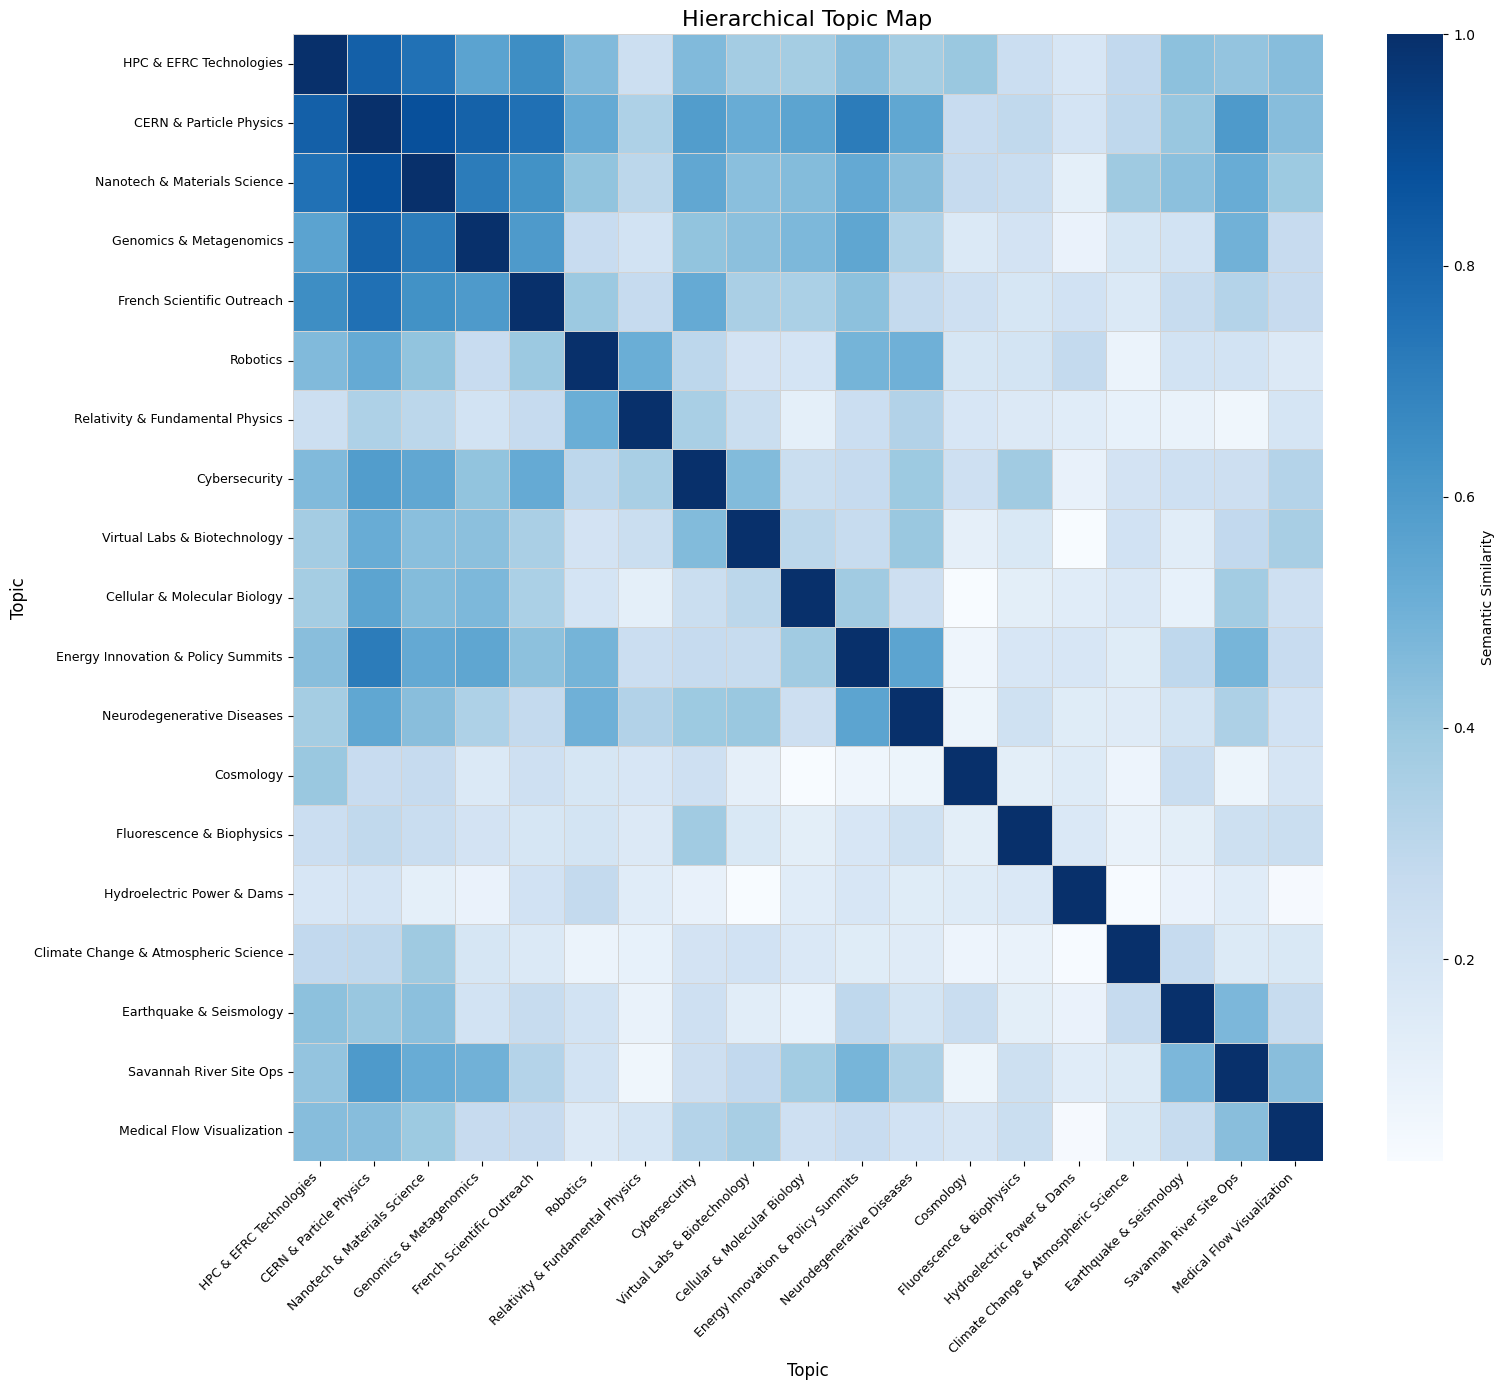


Manual Hierarchical Topic Map generated with Custom Names.


In [87]:
# Generate heatmap
plt.figure(figsize=(16, 14))

sns.heatmap(
    reordered_similarity_df,
    cmap="Blues",
    annot=False,
    fmt=".2f",
    linewidths=.5,
    linecolor='lightgray',
    xticklabels=custom_topic_labels_ordered,
    yticklabels=custom_topic_labels_ordered,
    cbar_kws={'label': 'Semantic Similarity'}
)

plt.title("Hierarchical Topic Map", fontsize=16)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Topic", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print("\nManual Hierarchical Topic Map generated with Custom Names.")